In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# NOTES : Outline of all functions in order and useage 

### Function that loads in any coordinate velocity and mass data of a given halo and returns these as numpy array and saved .npy files

### Function that Creates radial bins and denisty hist values for a simple rho(r) plot, and also make V_dispersion Profile. These radial bins are later used to make V_disperison as well

### NOTE:  Make sure radial bins are reset so that they are in the binning value in the middle of the bin

# remember to plot the values at the middle of the bin (not the edges)

## Set the halo to be loaded for analysis

In [2]:
halo = 'remus'   

In [3]:
%matplotlib inline
import numpy as np
from random import seed
from random import random
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.integrate as integrate
import matplotlib as mpl

# Must use aitoff module from Case Western
import aitoff as at
from matplotlib.backends.backend_pdf import PdfPages
d = 8.3   # kpc
conversion =  ( (1.989e30  * 5.586792179e26) **2 /  ((3.086e21)**5  )  )  # Conversion from Solar masses to particle physics units
plot_bins = 80

path = "/Users/danmckeown/" # path

my_rad = 300.0

# Functions 

# 1). 

In [4]:
def make_coords(coord_file,mass,velocities,mult_by):
    
    x = coord_file[:,0]
    y = coord_file[:,1]
    z = coord_file[:,2]  
            
    radius = np.sqrt(x*x + y*y  + z*z  )
    mask = radius <= my_rad
    radius_final = radius[mask]
    velocities_final = velocities[mask]
    velocities_final = np.asarray( velocities_final)
    part_mass = mass[0] * mult_by
    new_mass = np.zeros(len(radius_final))
    new_mass[:] = part_mass        
    x = x[mask]
    y = y[mask]
    z = z[mask]  
        
    return x,y,z,radius_final,new_mass,velocities_final,part_mass

# 2). 

In [5]:
def make_hist(radius,chosen_bins, masses, total_distance ):
    hist, bin_edges = np.histogram(radius, bins = chosen_bins, weights = masses, range = [0,total_distance])
    #...For Density plot                                                                                                                                                                        
    Vol = np.zeros(len(hist))
    for j in range(0, len(hist)):
        Vol[j] = 4.0/3.0* np.pi * (chosen_bins[j +1]**3 - chosen_bins[j]**3)
    
    # function adds an extra element we need to delete                                                                                                                                          
    chosen_bins_new = chosen_bins #chosen_bins[:-1]
    Den = list(map(truediv, hist, Vol))
    chosen_bins_new = np.asarray(chosen_bins_new)
    # Select the midpoint of each radial bin to plot
    chosen_bins_final =  (    chosen_bins_new[1:] + chosen_bins_new[:-1]) / 2.0 
    Den = np.asarray(Den)
    return chosen_bins_final,Den

# 3).

In [6]:
def make_velocities(velocities,radius,radial_bins,mult_by_vel):
    
    
    
    v_xav_dark = np.sum((velocities[:,0])) / ( len(velocities))
    v_yav_dark = np.sum((velocities[:,1])) / ( len(velocities))
    v_zav_dark = np.sum((velocities[:,2])) / ( len(velocities))

    v_av = [v_xav_dark,v_yav_dark,v_zav_dark ]

    velocities = velocities - v_av
    
    vx = velocities[:,0]
    vy = velocities[:,1]
    vz = velocities[:,2]
    
    v_xav_dark = np.sum((velocities[:,0])) / ( len(velocities))
    v_yav_dark = np.sum((velocities[:,1])) / ( len(velocities))
    v_zav_dark = np.sum((velocities[:,2])) / ( len(velocities))
    
    v_av = [v_xav_dark,v_yav_dark,v_zav_dark ]

    dispersion = np.zeros(radial_bins.size - 1)
 #   radial_bins = radial_bins[:-1]
    radial_bins_final =  ( radial_bins[1:] + radial_bins[:-1]) / 2.0 
    
    for i in range(1, len(radial_bins)): # Start at i = 1 since we're making shells                                                                                                                                                                        
     #   print (len(radius_dark),radial_bins_dark[i-1],radial_bins_dark[i]  )
        mask = (radius >  radial_bins[i-1]) & (radius < radial_bins[i])
        v_avg_dark = velocities[mask].mean(axis=0)
        difference_dark = velocities[mask] - v_avg_dark
        coord_var_dark = np.var(difference_dark, axis=0)
        dispersion[i-1] = np.sqrt(np.sum(coord_var_dark)) * mult_by_vel   
    return v_av,radial_bins_final,dispersion,vx,vy,vz

# 4). 

In [7]:





def local_density_weighting(file_name, radius, bin_edges,Den):

    rho_local = []
    #file_name = "rho_local_dm_m12i_new.npy"

    for i in range(len(radius)):

        local_d = (np.interp(radius[i] , bin_edges, Den, left= np.max(Den), right = np.min(Den), period=None))
        rho_local.insert( i, local_d )

    np.save(path+"/"+file_name+'.npy',rho_local)
    return rho_local
    

# 5).

In [8]:
def local_velocity_disp_weighting(file_name, radius, bin_edges, dispersion_sq):
    vel_disp_local_p = []
    #file_name = 'vel_disp_local_p'+ str(halo)
    length = len(dispersion_sq)
    final_value = length - 1
    for i in range(len(radius )):
         # Change radial_bins_dark to radial_bins_dark_half_way   , for left , assign the dispersion that is at smallest radii , then right should be value of dispersion at largest radii
        local_vel_p = (np.interp(radius[i] , bin_edges, dispersion_sq, left= dispersion_sq[0] , right= dispersion_sq[final_value], period=None))
        
        local_vel_p = ((local_vel_p) /( 2.99792458e5)**2 )        

        vel_disp_local_p.insert( i, local_vel_p )

    np.save(path+"/"+file_name+'.npy',vel_disp_local_p)
    return vel_disp_local_p
#vel_dm_only_p_wave = local_velocity_disp_weighting(dm_only_file_name_p, radius_dark, radial_bins_dark,dispersion_dark_sq)

# 6). 

In [9]:
def local_velocity_disp_weighting_d_wave(file_name, radius, bin_edges, dispersion_fourth):


    vel_disp_D_WAVE = []
    length = len(dispersion_fourth)
    final_value = length - 1    
   
    for i in range(len(radius )):

        local_vel_d = (np.interp(radius[i] , bin_edges, dispersion, left= dispersion_fourth[0], right= dispersion_fourth[final_value], period=None))
        local_vel_d = ((local_vel_d) /( 2.99792458e5)**4 )

        vel_disp_D_WAVE.insert( i, local_vel_d )

    np.save(path+"/"+file_name+'.npy',vel_disp_D_WAVE)
    return vel_disp_D_WAVE

# 7). 

In [10]:
def coord_trans( x,y,z,d,weights ):

    x = (x + d)
    
    Phi = np.arctan2(y ,x)
    radius = np.sqrt(( x  )*(  x ) + (y )* (y ) + (z )*(z  ) )        
    u = (z  )  / ( radius )
    Theta = np.arccos(u)
    
    Cos_Psi = (x) /(radius)
    
    a = 0.4
    # a is the softening length.  
    
    Angle_weighting =  ( weights) /  (radius + a)**2    # Weights can either be in terms of rho* density  or rho*density *sigma**2,  or rho* density * sigma**4
    
    
    return Phi,Theta,radius,Angle_weighting,Cos_Psi

# NOTE: Just Use 7 for velocities and use velocities weights in place of weighting mass and rho ( in other words multiply it by that)

# 8).

In [11]:
def hammer_projection(Phi_deg_array, Theta_deg_array , Final_weighting, plot_bins,lower_limit,upper_limit,file_name,color_map,title,x_lim,y_lim,run_type,wave_type):
      
    
    lz = 180
    #sampling of aitoff projection
    #RA,l, or Lambda Sgr
    binner1 = np.linspace(-180.,180.,plot_bins)
    #DEC, b, or B Sgr
    binner2 = np.linspace(-90.,90.,plot_bins)
    fig, ax = plt.subplots()#create figure in inches


    ### Moment AT.Project is used
    l, b = at.project(Phi_deg_array,Theta_deg_array,lz)

    #Create density map
    #img, xbins,ybins = np.histogram2d(ra,dec, weights = Angle_weighting_NFW, bins=(binner1,binner2) )
    img, xbins,ybins = np.histogram2d(l,b, weights = Final_weighting, bins=(binner1,binner2) )

    img = np.log10(img)

    print(len(img))

    dark_only_vmax = np.max(img)
    dark_only_vmin = np.percentile(img, 25)
    
    print(np.max(Final_weighting))
    print(np.median(Final_weighting))
    print(np.percentile(Final_weighting, 25))
    print(np.min(img))

    #Import a module to make minor ticks
    from matplotlib.ticker import AutoMinorLocator
    #Set up to tell matplotlib to autoselect minor tick locations
    minorLocator   = AutoMinorLocator()

    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)


    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on
    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=7)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)
    ax.set_ylim([-25.,90.])
    ax.set_ylabel('DEC',fontsize=18)
    ax.set_xlabel('RA',fontsize=18)

    #fig.gca().invert_xaxis()


    #create a figure to plot the histogram on
    fig, ax = plt.subplots(figsize=(12.,6.))#create figure in inches
    plot = ax.imshow(img.T,origin='lower',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
                     cmap=plt.cm.binary,interpolation='bicubic',aspect='auto' #try a different interpolation method for the image
                     ,vmin = lower_limit, vmax = upper_limit)
    #Add a nice little color bar
    cbar = fig.colorbar(plot)
    cbar.set_label('Density of Dark Matter')
    #put a gid on the plot 
    at.gridlines(lz,fig,ax)
    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on

    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=7)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)

    #remove axis labels because they are meanles in an aitoff projection
    fig.gca().get_xaxis().set_visible(False)
    fig.gca().get_yaxis().set_visible(False)
    fig.gca().invert_xaxis()


    import matplotlib as mat

    #create a figure to plot the histogram on
    fig, ax = plt.subplots(figsize=(14.,10.))#create figure in inches
    #create a colorbar axis
    cax, kw = mat.colorbar.make_axes(ax,pad=0,shrink=1.0,location='top',fontsize = 14)


    #imshow will also do RGB if you feed it a 3d or 4d array ( the last dimension being opcacity)
    plot = ax.imshow(img.T,origin='lower',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
                     cmap= color_map,#try a different color scheme for the image
                     interpolation='bilinear',aspect='auto', 
                     vmin = lower_limit, vmax = upper_limit)
    #Add a nice little color bar
    cbar = fig.colorbar(plot,cax=cax,orientation='horizontal')
    
    cbar.set_label(title, fontsize = 25 , y = 1.28 )
    
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(labelsize=20) 
    
    #mpl.pyplot.text( 21.1,19, str(halo)+': S-Wave DMO', fontsize = 17, color = 'black' )
    mpl.pyplot.text( x_lim[0],y_lim[0],  wave_type , fontsize = 34, color = 'black' )
    mpl.pyplot.text( x_lim[1],y_lim[1], str(halo) , fontsize = 34, color = 'black' )

    mpl.pyplot.text( x_lim[2],y_lim[2],  run_type , fontsize = 34, color = 'black' )
   
    #cbar.ax.set_xticklabels()
    #put a gid on the plot 
    at.gridlines(lz,fig,ax)
    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on
    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=8)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)

    #remove axis labels because they are meanles in an aitoff projection
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #because it drops all axes for whatever reason
    cax.get_xaxis().set_visible(True)
    ax.set_xlim([180.,-180.])
    ax.set_ylim([-90.,90.])
    
    plt.savefig(path + '/' +file_name_of_hammer+wave_type+str(halo)+'.png')
    
    
    
    print ('printing max value of DJ/DO')
    print (np.max(img))
    print ('printing x and y bins')
    return xbins,ybins



In [12]:
def hammer_projection_new(Phi_deg_array, Theta_deg_array , Final_weighting, plot_bins,lower_limit,upper_limit,file_name,color_map,title,x_lim,y_lim,run_type,wave_type,calc):
      
    
    lz = 180
    #sampling of aitoff projection
    #RA,l, or Lambda Sgr
    binner1 = np.linspace(-180.,180.,plot_bins)
    #DEC, b, or B Sgr
    binner2 = np.linspace(-90.,90.,plot_bins)
    fig, ax = plt.subplots()#create figure in inches


    ### Moment AT.Project is used
    l, b = at.project(Phi_deg_array,Theta_deg_array,lz)

    #Create density map
    #img, xbins,ybins = np.histogram2d(ra,dec, weights = Angle_weighting_NFW, bins=(binner1,binner2) )
    img, xbins,ybins = np.histogram2d(l,b, weights = Final_weighting, bins=(binner1,binner2) )

    img = np.log10(img)

    print(len(img))

    dark_only_vmax = np.max(img)
    dark_only_vmin = np.percentile(img, 25)
    
    print(np.max(Final_weighting))
    print(np.median(Final_weighting))
    print(np.percentile(Final_weighting, 25))
    print(np.min(img))

    #Import a module to make minor ticks
    from matplotlib.ticker import AutoMinorLocator
    #Set up to tell matplotlib to autoselect minor tick locations
    minorLocator   = AutoMinorLocator()

    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)


    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on
    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=7)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)
    ax.set_ylim([-25.,90.])
    ax.set_ylabel('DEC',fontsize=18)
    ax.set_xlabel('RA',fontsize=18)

    #fig.gca().invert_xaxis()


    #create a figure to plot the histogram on
    fig, ax = plt.subplots(figsize=(12.,6.))#create figure in inches
    plot = ax.imshow(img.T,origin='lower',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
                     cmap=plt.cm.binary,interpolation='bicubic',aspect='auto' #try a different interpolation method for the image
                     ,vmin = lower_limit, vmax = upper_limit)
    #Add a nice little color bar
    cbar = fig.colorbar(plot)
    cbar.set_label('Density of Dark Matter')
    #put a gid on the plot 
    at.gridlines(lz,fig,ax)
    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on

    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=7)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)

    #remove axis labels because they are meanles in an aitoff projection
    fig.gca().get_xaxis().set_visible(False)
    fig.gca().get_yaxis().set_visible(False)
    fig.gca().invert_xaxis()


    import matplotlib as mat

    #create a figure to plot the histogram on
    fig, ax = plt.subplots(figsize=(14.,10.))#create figure in inches
    #create a colorbar axis
    cax, kw = mat.colorbar.make_axes(ax,pad=0,shrink=1.0,location='top',fontsize = 14)


    #imshow will also do RGB if you feed it a 3d or 4d array ( the last dimension being opcacity)
    plot = ax.imshow(img.T,origin='lower',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
                     cmap= color_map,#try a different color scheme for the image
                     interpolation='bilinear',aspect='auto', 
                     vmin = lower_limit, vmax = upper_limit)
    #Add a nice little color bar
    cbar = fig.colorbar(plot,cax=cax,orientation='horizontal')
    
    cbar.set_label(title, fontsize = 25 , y = 1.28 )
    
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(labelsize=20) 
    
    #mpl.pyplot.text( 21.1,19, str(halo)+': S-Wave DMO', fontsize = 17, color = 'black' )
    mpl.pyplot.text( x_lim[0],y_lim[0],  wave_type , fontsize = 34, color = 'black' )
    mpl.pyplot.text( x_lim[1],y_lim[1], str(halo) , fontsize = 34, color = 'black' )
    mpl.pyplot.text( x_lim[3],y_lim[1], calc , fontsize = 28, color = 'black' )

    mpl.pyplot.text( x_lim[2],y_lim[2],  run_type , fontsize = 34, color = 'black' )
   
    #cbar.ax.set_xticklabels()
    #put a gid on the plot 
    at.gridlines(lz,fig,ax)
    #Actually tell matplotlib to find best minor tick locations
    ax.xaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_minor_locator(minorLocator)
    #Turn minor ticks on
    ax.minorticks_on()
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=8)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3)

    #remove axis labels because they are meanles in an aitoff projection
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #because it drops all axes for whatever reason
    cax.get_xaxis().set_visible(True)
    ax.set_xlim([180.,-180.])
    ax.set_ylim([-90.,90.])
    
    plt.savefig(path + '/' +file_name_of_hammer+wave_type+str(halo)+'.png')
    
    
    
    print ('printing max value of DJ/DO')
    print (np.max(img))
    print ('printing x and y bins')
    return xbins,ybins



# 9). 

In [13]:
def Angle_convert( Theta,Phi):


    Theta_deg = np.degrees(Theta - np.pi/2)
    Phi_deg = np.degrees(Phi + np.pi)    

    Theta_deg_array = np.asarray( Theta_deg)
    Phi_deg_array = np.asarray( Phi_deg)

    
    return Theta_deg_array,Phi_deg_array


# 10).

In [14]:

def recenter( coords, dm_mass, center_range):

    radius = np.sqrt ( coords[:,0]*coords[:,0] +  coords[:,1]*coords[:,1] + coords[:,2]*coords[:,2] )

    index1 = radius < center_range

    xyz2 = coords[index1]
    
    dm_mass2 = dm_mass[index1]

    mp = 0
    for j in range (0, len(xyz2)):
    # sum all the mass times coordinates                                                                                                                                                                                                \

        mp = dm_mass2[j] * xyz2[j,:] + mp

    DM_mass_tot1 = len(xyz2) * dm_mass2[0]
    
    DM_cm = mp/DM_mass_tot1
    print ('printing dm cm')
    print (DM_cm)
    print(dm_mass2[0])
    new_coords = coords - DM_cm    
    
    
    return new_coords

# 11).

In [15]:

def recenter_bary( coords, dm_mass, center_range):

    radius = np.sqrt ( coords[:,0]*coords[:,0] +  coords[:,1]*coords[:,1] + coords[:,2]*coords[:,2] )

    index1 = radius < center_range

    xyz2 = coords[index1]
    
    dm_mass2 = dm_mass[index1]

    mp = 0
    for j in range (0, len(xyz2)):
    # sum all the mass times coordinates                                                                                                                                                                                                \

        mp = dm_mass2[j] * xyz2[j,:] + mp

    DM_mass_tot1 = len(xyz2) * dm_mass2[0]
    
    DM_cm = mp/DM_mass_tot1
    print ('printing dm cm')
    print (DM_cm)
    print(dm_mass2[0])
    new_coords_bary = coords - DM_cm    
    
    
    return new_coords_bary

#  NEED TO MAKE NOTES TO THIS SECTION OF CODE FOR CLAIRIFICATION 

# 12). 

In [16]:

import numpy as np
import ctypes
import math
import os.path
import struct
import array

def checklen(x):
    return len(np.array(x,ndmin=1));
def fcor(x):
    return np.array(x,dtype='f',ndmin=1)
def vfloat(x):
    return x.ctypes.data_as(ctypes.POINTER(ctypes.c_float));

def ok_scan(input,xmax=1.0e10,pos=0):
    if (pos==1):
        return (np.isnan(input)==False) & (abs(input)<=xmax) & (input > 0.);
    else:
        return (np.isnan(input)==False) & (abs(input)<=xmax);
    
    
    
    
def get_particle_hsml( x, y, z, vx, vy, vz, DesNgb=32, Hmax=0.):
    
    
    x=fcor(x); y=fcor(y); z=fcor(z); N=checklen(x); 

    vx=fcor(vx); vy=fcor(vy); vz=fcor(vz); N=checklen(x); 
    
    ok=(ok_scan(x) & ok_scan(y) & ok_scan(z));
    ok= ok & (ok_scan(vx) & ok_scan(vy) & ok_scan(vz));

    x=x[ok]; y=y[ok]; z=z[ok];
    vx=vx[ok]; vy=vy[ok]; vz=vz[ok];

    
    if(Hmax==0.):
        dx=np.max(x)-np.min(x); dy=np.max(y)-np.min(y); dz=np.max(z)-np.min(z); ddx=np.max([dx,dy,dz]);
        Hmax=5.*ddx*(np.float(N)**(-1./3.)); ## mean inter-particle spacing                                                                                                                                                                                   

  
  ##### now accessing the C code

    import inspect
    exec_call = "/Users/danmckeown/repos/FIRE_studio/firestudio/utils/stellar_utils/c_libraries/StellarHsml/starhsml.so"
    
    # calling program in the dir.
    h_routine=ctypes.cdll[exec_call];

    # These are python variables which we are casting as C variables
    h_out_cast=ctypes.c_float*N; H_OUT=h_out_cast();
    v_mag_cast=ctypes.c_float*N; V_MAG=v_mag_cast();
    v_out_cast=ctypes.c_float*N; V_OUT=v_out_cast();
    
    # First variable name needs to match last
    
    # These lines create the pointers that are passed to the C code  ( ctypes.byref(H_OUT), ctypes.byref(V_OUT))
    
    
    ## main call to the hsml-finding routine
    h_routine.stellarhsml( ctypes.c_int(N), \
    ## load the routine we need                                                                                                                                                                                                                               
    
        vfloat(x), vfloat(y), vfloat(z), \
        vfloat(vx), vfloat(vy), vfloat(vz), ctypes.c_int(DesNgb), \
        ctypes.c_float(Hmax), ctypes.byref(H_OUT), ctypes.byref(V_OUT),ctypes.byref(V_MAG)
    )                       
                          
    ## now put the output arrays into a useful format 
    
    # These two lines below get the pointers out
    h = np.ctypeslib.as_array(np.copy(H_OUT));                     
    vmag = np.ctypeslib.as_array(np.copy(V_MAG));

    vdisp = np.ctypeslib.as_array(np.copy(V_OUT));
    
    return h, vmag, vdisp
                          
   

# Files 

In [17]:
R_virial_bary =  np.load(path+"/"+'Virial_remus_bary.npy')

R_virial_dark =  np.load(path+"/"+'virial_remus.npy')


velocities_bary = np.load(path+"/"+ 'velocities_dm_baryrom_rem_remus.npy')
bary_coords = np.load(path+"/"+'bary_coord_dm_rom_rem_remus_newest.npy')

dm_mass_bary  = np.load(path+"/"+ 'dm_mass_unrot_bary_remus.npy' )




velocities_dark = np.load(path+"/"+ 'velocities_rom_rem_dark_remus.npy')
dm_mass_dark  = np.load(path+"/"+ 'dm_massrom_rem_dark_remus.npy')
dark_coords = np.load(path+"/"+'dark_coordsrom_rem_dark_remus.npy')


   
print(len(velocities_bary))
print(len(bary_coords))
print(len(dm_mass_bary))


print(len(velocities_dark))
print(len(dark_coords))
print(len(dm_mass_dark))



print(dm_mass_dark[0])
print(dm_mass_bary[0])





54101790
54101790
54101790
58269014
58269014
58269014
23640.537414983453
19650.086177931935


# Make Un normalized Density Plots For DMO and Baryonic 

In [18]:

pos_x_dark,pos_y_dark,pos_z_dark,radius_dark,dm_mass_dark_final,velocities_dark_final,dm_only_mass = make_coords(dark_coords,dm_mass_dark,velocities_dark,1.0)

pos_x_bary,pos_y_bary,pos_z_bary,radius_bary,dm_mass_bary_final,velocities_bary_final,dm_bary_mass = make_coords(bary_coords,dm_mass_bary,velocities_bary,1.0)


print (np.max(radius_bary))
dm_mass_dark_final = np.asarray(dm_mass_dark_final)
dm_mass_bary_final = np.asarray(dm_mass_bary_final)



#print(len(dm_mass_dark_final))
print(len(dm_mass_bary_final))

#print(dm_only_mass)
print(dm_bary_mass)


299.99999905134734
52881104
19650.086177931935


In [19]:
from operator import truediv
my_bins = 100


#binning_dark = np.logspace(np.log10(0.1),np.log10(300.), my_bins)
#binning_bary = np.logspace(np.log10(0.1),np.log10(300.), my_bins)


#dark_radial_bins, Den_dark = make_hist(radius_dark,binning_dark, dm_mass_dark_final, 300 )
#bary_radial_bins, Den_bary = make_hist(radius_bary,binning_bary, dm_mass_bary_final, 300 )

binning_dark = np.logspace(np.log10(0.1),np.log10(150.), my_bins)
binning_bary = np.logspace(np.log10(0.1),np.log10(150.), my_bins)


dark_radial_bins, Den_dark = make_hist(radius_dark,binning_dark, dm_mass_dark_final, 150 )
bary_radial_bins, Den_bary = make_hist(radius_bary,binning_bary, dm_mass_bary_final, 150 )




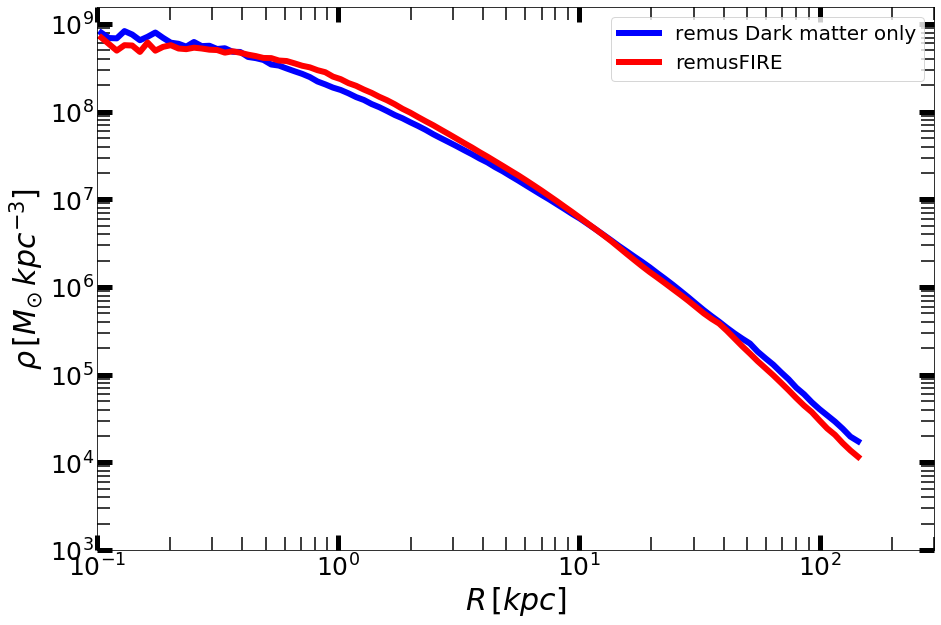

In [20]:
ax_font = 25
txt_font = 30
lw = 4

######################
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(which='major',width=5,length=15, direction = 'in', top = True ,right = True, labelsize = ax_font)

ax.tick_params(which='minor',width= 1.5,length=13, direction = 'in', top = True ,right = True, labelsize = ax_font)

plt.xlabel(r'$R\, [kpc]$', fontsize = 30)
plt.ylabel(r'$\rho\, [M_{\odot}\, kpc^{-3}]$', fontsize = 30)

plt.loglog(dark_radial_bins, Den_dark, linewidth= 6, color = 'Blue',label = str(halo)+' Dark matter only' )
plt.loglog(bary_radial_bins,  Den_bary  ,  linewidth= 6, color = 'Red', label = str(halo)+''+'FIRE' )





np.save(path+"/"+'density_dark_un_norm'+str(halo)+'.npy',Den_dark)
np.save(path+"/"+'dark_bins_rho_un_norm'+str(halo)+'.npy',dark_radial_bins)
np.save(path+"/"+'density_bary_un_norm'+str(halo)+'.npy',Den_bary)
np.save(path+"/"+'bary_bins_rho_un_norm'+str(halo)+'.npy',bary_radial_bins)







plt.xlim(    0.1, 300)
plt.ylim(    10**3, 10**9.2)
plt.legend(fontsize = 20)
plt.savefig(path +'Dark_matter_density.png')
plt.show()

                         
#=====================  3.Plot the data  =====================

# Now Use Interpolation to determine the value at which normalization needs to be done to 

In [21]:
print(np.interp(10000, dark_radial_bins, Den_dark, left= np.max(Den_dark), right= np.min(Den_dark), period=None))
print(np.interp(0, dark_radial_bins, Den_dark, left= np.max(Den_dark), right= np.min(Den_dark), period=None))

local_rho_dark = (np.interp(8.3, dark_radial_bins, Den_dark, left= np.max(Den_dark), right= np.min(Den_dark), period=None))
print (1.e7/local_rho_dark)

mult_dark = 1.e7/local_rho_dark


local_rho_bary = (np.interp(8.3, bary_radial_bins, Den_bary, left= np.max(Den_bary), right= np.min(Den_bary), period=None) )
print(1.e7/local_rho_bary)

mult_bary = 1.e7/local_rho_bary

vel_norm_dark = np.sqrt(mult_dark )

vel_norm_bary = np.sqrt(mult_bary )


17399.47937411417
830779645.6623893
1.1785793535252116
1.0940333130231468


In [22]:
pos_x_dark,pos_y_dark,pos_z_dark,radius_dark,dm_mass_dark_final,velocities_dark_final,dm_only_mass = make_coords(dark_coords,dm_mass_dark,velocities_dark,mult_dark)

pos_x_bary,pos_y_bary,pos_z_bary,radius_bary,dm_mass_bary_final,velocities_bary_final,dm_bary_mass = make_coords(bary_coords,dm_mass_bary,velocities_bary,mult_bary)


dm_mass_dark_final = np.asarray(dm_mass_dark_final)
dm_mass_bary_final = np.asarray(dm_mass_bary_final)

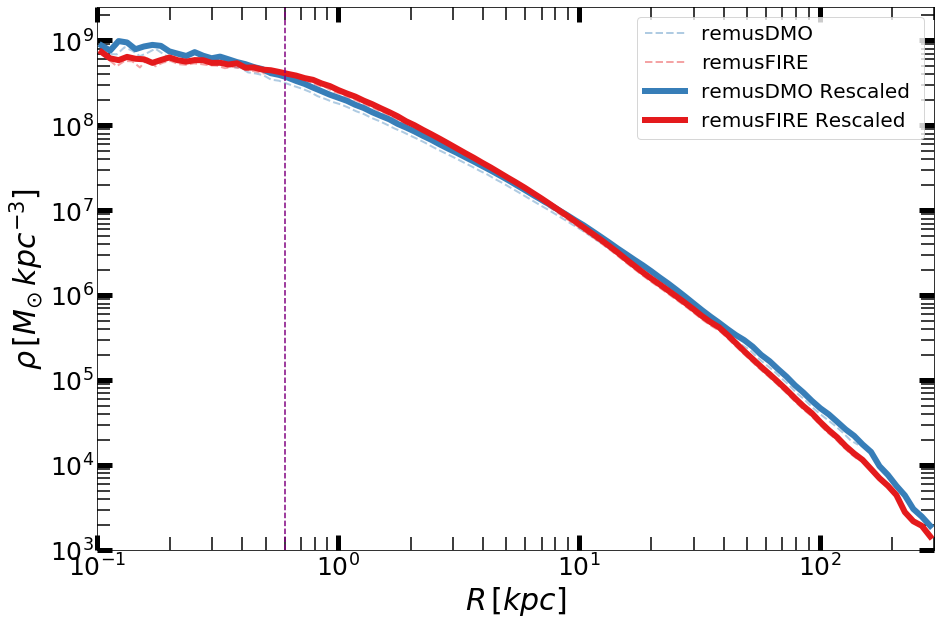

In [23]:
from operator import truediv
my_bins = 100


binning_dark = np.logspace(np.log10(0.1),np.log10(300.), my_bins)
binning_bary = np.logspace(np.log10(0.1),np.log10(300.), my_bins)


dark_radial_bins_new, Den_dark_new = make_hist(radius_dark,binning_dark, dm_mass_dark_final, 300 )
bary_radial_bins_new, Den_bary_new = make_hist(radius_bary,binning_bary, dm_mass_bary_final, 300 )





CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']






ax_font = 25
txt_font = 30
lw = 4

######################
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(which='major',width=5,length=15, direction = 'in', top = True ,right = True, labelsize = ax_font)

ax.tick_params(which='minor',width= 1.5,length=13, direction = 'in', top = True ,right = True, labelsize = ax_font)

plt.xlabel(r'$R\, [kpc]$', fontsize = 30)
plt.ylabel(r'$\rho\, [M_{\odot}\, kpc^{-3}]$', fontsize = 30)
plt.loglog(dark_radial_bins, Den_dark, linewidth= 2,linestyle='--', alpha =0.4 ,color =  CB_color_cycle[0],label = str(halo)+'DMO ' )
plt.loglog(bary_radial_bins,  Den_bary  ,  linewidth= 2,linestyle='--', alpha = 0.4,color =  CB_color_cycle[7], label = str(halo)+''+'FIRE' )

plt.loglog(dark_radial_bins_new, Den_dark_new, linewidth= 6, color =  CB_color_cycle[0],label = str(halo)+'DMO Rescaled ' )
plt.loglog(bary_radial_bins_new,  Den_bary_new  ,  linewidth= 6, color =  CB_color_cycle[7], label = str(halo)+''+'FIRE Rescaled' )



np.save(path+"/"+'density_dark'+str(halo)+'.npy',Den_dark_new)
np.save(path+"/"+'dark_bins_rho'+str(halo)+'.npy',dark_radial_bins_new)
np.save(path+"/"+'density_bary'+str(halo)+'.npy',Den_bary_new)
np.save(path+"/"+'bary_bins_rho'+str(halo)+'.npy',bary_radial_bins_new)






#plt.loglog(rad,rho_test,color = 'orange', linestyle='--', linewidth=3, label = ' NFW')
plt.axvline(x= .6, color = 'purple',linestyle='--')
#plt.axvline(x= 8.3, color = 'orange',linestyle='--')

plt.xlim(    0.1, 300)
plt.ylim(    10**3, 10**9.4)
plt.legend(fontsize = 20)
plt.savefig(path +'Dark_matter_density'+str(halo)+'.png',   bbox_inches='tight' )
plt.show()

                         
#=====================  3.Plot the data  =====================

In [24]:


v_av_dark,radial_bins_dark,dispersion_dark_basic, vx_dark, vy_dark,vz_dark = make_velocities(velocities_dark_final,radius_dark,binning_dark,vel_norm_dark)

v_av_bary,radial_bins_bary,dispersion_bary_basic, vx_bary, vy_bary,vz_bary = make_velocities(velocities_bary_final,radius_bary,binning_bary,vel_norm_bary)


In [25]:
print(len(velocities_dark_final))
print(len(velocities_bary_final))


54767627
52881104


In [26]:
print(len(dm_mass_dark_final))
print(len(dm_mass_bary_final))

print(dm_only_mass)
print(dm_bary_mass)

#binning_dark = np.arange(0,300,0.5)
#binning_bary = np.arange(0, 300,0.5)
# Old binning above


v_av_dark_un_norm,radial_bins_dark_un_norm,dispersion_dark_basic_un_norm,vx_dark_un_norm, vy_dark_un_norm,vz_dark_un_norm = make_velocities(velocities_dark_final,radius_dark,binning_dark,1.0)

v_av_bary_un_norm,radial_bins_bary_un_norm,dispersion_bary_basic_un_norm , vx_bary_un_norm, vy_bary_un_norm, vz_bary_un_norm = make_velocities(velocities_bary_final,radius_bary,binning_bary,1.0)

54767627
52881104
27862.249303539775
21497.84888243322


371.1660920171604


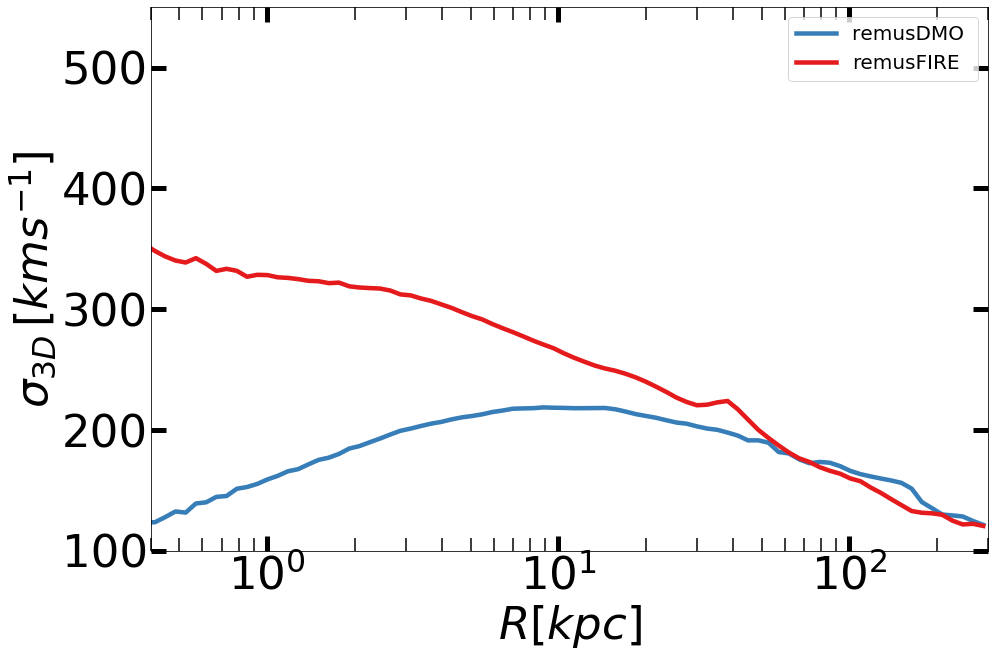

In [27]:

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']



ax_font = 45
txt_font = 45
lw = 4


fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(which='major',width=5,length=15, direction = 'in', top = True ,right = True, labelsize = ax_font)

ax.tick_params(which='minor',width= 1.5,length=13, direction = 'in', top = True ,right = True, labelsize = ax_font)

plt.xlabel(r'$R [kpc]$',  fontsize = ax_font)
plt.ylabel(r'$\sigma_{3D}\, [ km s^{-1}]$',  fontsize = ax_font)


plt.semilogx(radial_bins_dark_un_norm, dispersion_dark_basic_un_norm, linewidth= 4.5, color = CB_color_cycle[0],label = str(halo)+ 'DMO ')

plt.semilogx(radial_bins_bary_un_norm, dispersion_bary_basic_un_norm, linewidth= 4.5, color = CB_color_cycle[7],label = str(halo)+ 'FIRE' )


ax.legend(loc=0, fontsize = 20)

plt.xlim(    0.4, 300.)
plt.ylim(    100, 550.0)



np.save(path+"/"+'disp_dark_un_norm'+str(halo)+'.npy',dispersion_dark_basic_un_norm)
np.save(path+"/"+'dark_bins_vel_disp_un_norm'+str(halo)+'.npy',radial_bins_dark_un_norm)

np.save(path+"/"+'disp_bary_un_norm'+str(halo)+'.npy',dispersion_bary_basic_un_norm)
np.save(path+"/"+'bary_bins_vel_disp_un_norm'+str(halo)+'.npy',radial_bins_bary_un_norm)







plt.savefig(path +'Velocity_dispersion_un_norm'+str(halo)+'.png', bbox_inches='tight')
#plt.title( r'$\sigma $' + ' ' + str(halo)+ ' '+ 'DMO vs.FIRE', fontsize = 40)                                                                                                                                                                 
#plt.xlabel(r'$Radius\, [kpc]$', fontsize = 30)

#plt.ylabel(r'$\sigma_{disp}\, [ km s^{-1}]$')

print(np.max(dispersion_bary_basic_un_norm ))


# Here we use the dispersions that will be used to find the velocity dispersions estimate for nans later on 

388.2250615128867


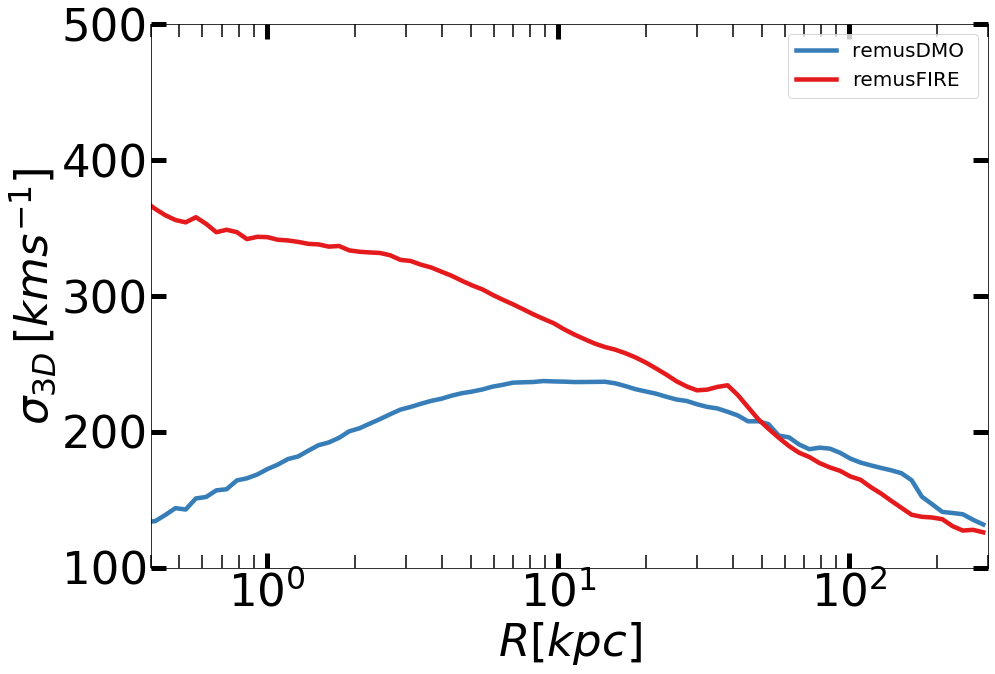

In [28]:

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']



ax_font = 45
txt_font = 45
lw = 4


fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(which='major',width=5,length=15, direction = 'in', top = True ,right = True, labelsize = ax_font)

ax.tick_params(which='minor',width= 1.5,length=13, direction = 'in', top = True ,right = True, labelsize = ax_font)

plt.xlabel(r'$R [kpc]$',  fontsize = ax_font)
plt.ylabel(r'$\sigma_{3D}\, [ km s^{-1}]$',  fontsize = ax_font)


plt.semilogx(radial_bins_dark, dispersion_dark_basic, linewidth= 4.5, color = CB_color_cycle[0],label = str(halo)+ 'DMO ')

plt.semilogx(radial_bins_bary, dispersion_bary_basic, linewidth= 4.5, color = CB_color_cycle[7],label = str(halo)+ 'FIRE' )


ax.legend(loc=0, fontsize = 20)

plt.xlim(    0.4, 300)
plt.ylim(    100., 500.)


np.save(path+"/"+'disp_dark'+str(halo)+'.npy',dispersion_dark_basic)
np.save(path+"/"+'dark_bins_vel_disp'+str(halo)+'.npy',radial_bins_dark)

np.save(path+"/"+'disp_bary'+str(halo)+'.npy',dispersion_bary_basic)
np.save(path+"/"+'bary_bins_vel_disp'+str(halo)+'.npy',radial_bins_bary)




plt.savefig(path +'Velocity_dispersion'+str(halo)+'.png', bbox_inches='tight')
#plt.title( r'$\sigma $' + ' ' + str(halo)+ ' '+ 'DMO vs.FIRE', fontsize = 40)                                                                                                                                                                 
#plt.xlabel(r'$Radius\, [kpc]$', fontsize = 30)

#plt.ylabel(r'$\sigma_{disp}\, [ km s^{-1}]$')

print(np.max(dispersion_bary_basic ))


#  Find the velocity Dispersion weighting the old fashioned way 

# 13   (p wave)

In [29]:
def local_velocity_disp_weighting_p(file_name, radius, bin_edges, dispersion_sq):
    vel_disp_local_p = []
    #file_name = 'vel_disp_local_p'+ str(halo)
    length = len(dispersion_sq)
    final_value = length - 1
    for i in range(len(radius )):
         # Change radial_bins_dark to radial_bins_dark_half_way   , for left , assign the dispersion that is at smallest radii , then right should be value of dispersion at largest radii
        local_vel_p = (np.interp(radius[i] , bin_edges, dispersion_sq, left= dispersion_sq[0] , right= dispersion_sq[final_value], period=None))
        #print(local_vel_p)
        local_vel_p = ((local_vel_p) /( 2.99792458e5)**2 )        
        #print(local_vel_p)
        vel_disp_local_p.insert( i, local_vel_p )

    np.save(path+"/"+file_name+'.npy',vel_disp_local_p)
    return vel_disp_local_p
#vel_dm_only_p_wave = local_velocity_disp_weighting(dm_only_file_name_p, radius_dark, radial_bins_dark,dispersion_dark_sq)

# 14   (d wave)

In [30]:
def local_velocity_disp_weighting_d(file_name, radius, bin_edges, dispersion_fourth):
    vel_disp_local_d = []
    #file_name = 'vel_disp_local_p'+ str(halo)
    length = len(dispersion_fourth)
    final_value = length - 1
    for i in range(len(radius )):
         # Change radial_bins_dark to radial_bins_dark_half_way   , for left , assign the dispersion that is at smallest radii , then right should be value of dispersion at largest radii
        local_vel_d = (np.interp(radius[i] , bin_edges, dispersion_fourth, left= dispersion_fourth[0] , right= dispersion_fourth[final_value], period=None))
        #print(local_vel_p)
        local_vel_d = ((local_vel_d) /( 2.99792458e5)**4 )        
        #print(local_vel_p)
        vel_disp_local_d.insert( i, local_vel_d )

    np.save(path+"/"+file_name+'.npy',vel_disp_local_d)
    return vel_disp_local_d
#vel_dm_only_p_wave = local_velocity_disp_weighting(dm_only_file_name_p, radius_dark, radial_bins_dark,dispersion_dark_sq)

#    Now Finding the local density and Local Velocity Dispersion

# This is needed for advanced local weighting !!!!!

In [31]:
smoothing_length_dark, v_disp_dark, v_mag_dark = get_particle_hsml( pos_x_dark,  pos_y_dark,  pos_z_dark, vx_dark, vy_dark, vz_dark )



volumes_d = (4./3.) * np.pi * (smoothing_length_dark)**3


masses_d = 32. * dm_mass_dark_final


rho = masses_d/volumes_d



np.save(path+"/"+'full_density_s_dark_'+str(halo)+'.npy',rho)
 
    
np.save(path+"/"+'full_disp_s_dark_'+str(halo)+'.npy',v_disp_dark)




In [32]:


np.save(path+"/"+'full_mag_s_dark_'+str(halo)+'.npy',v_mag_dark)
print(np.min(v_disp_dark))

print(np.sum(v_mag_dark))

1.1675748
10450670000.0


In [33]:



print(np.average((v_disp_dark)))

print(np.average(v_mag_dark))

print(np.max(v_disp_dark))

print(np.max(v_mag_dark))

print(v_mag_dark[5])
print(v_disp_dark[5])
print(np.max(v_mag_dark))
print(np.max(v_disp_dark))

151.21832
190.81837
316.21017
718.14923
385.43365
215.73518
718.14923
316.21017


In [34]:
###############################################


smoothing_length_bary, v_disp_bary,v_mag_bary = get_particle_hsml( pos_x_bary,  pos_y_bary,  pos_z_bary, vx_bary, vy_bary, vz_bary )



volumes_b = (4./3.) * np.pi * (smoothing_length_bary)**3


masses_b = 32. * dm_mass_bary_final


rho_b = masses_b/volumes_b



np.save(path+"/"+'full_density_s_bary_'+str(halo)+'.npy',rho_b)
 
    
np.save(path+"/"+'full_disp_s_bary_'+str(halo)+'.npy',v_disp_bary)



In [35]:


np.save(path+"/"+'full_mag_s_bary_'+str(halo)+'.npy',v_mag_bary)

In [36]:


print(np.average((v_disp_bary)))

print(np.average(v_mag_bary))

163.2341
206.91858


# Load Files 

In [37]:
v_disp_dark =  np.load(path+"/"+'full_disp_s_dark_'+str(halo)+'.npy')
v_mag_dark = np.load(path+"/"+'full_mag_s_dark_'+str(halo)+'.npy')
rho = np.load(path+"/"+'full_density_s_dark_'+str(halo)+'.npy')

v_disp_bary =  np.load(path+"/"+'full_disp_s_bary_'+str(halo)+'.npy')
v_mag_bary = np.load(path+"/"+'full_mag_s_bary_'+str(halo)+'.npy')

rho_b = np.load(path+"/"+'full_density_s_bary_'+str(halo)+'.npy')


In [38]:
#list1 = [10, -21, 4, -45, 66, -93, 1]
  
pos_count, neg_count = 0, 0
  
# iterating each number in list
for num in v_mag_dark:
      
    # checking condition
    if num >= 0:
        pos_count += 1
  
    else:
        neg_count += 1
          
print("Positive numbers in the list: ", pos_count)
print("Negative numbers in the list: ", neg_count)

Positive numbers in the list:  54767627
Negative numbers in the list:  0


In [39]:
print(np.average( v_mag_bary))
print(np.average(v_disp_bary))

206.91858
163.2341


# Find the Nans

In [40]:
print(np.sum(v_disp_dark))
print(np.min(v_mag_dark))
print(len((np.argwhere(np.isnan(v_disp_dark)))))
print(len((np.argwhere(np.isnan(v_mag_dark)))))
ratio = (v_disp_dark/v_mag_dark)
print(np.min(ratio))


8281868300.0
1.1582786
0
0
0.17966945



# Dark only nans is an array of indices that are nans. Use this array of indices to act on the density array before multiplying to get the Local J factor. 

In [41]:
dark_only_nans = (np.argwhere(np.isnan(v_disp_dark)))
dark_only_nans = dark_only_nans.flatten()
print(dark_only_nans)

print(len(dark_only_nans))

leftover_radii_D = radius_dark[dark_only_nans]
np.save(path+"/"+'dark_nans_juliet'+'.npy',dark_only_nans)

np.save(path+"/"+'left_over_radii_d_'+str(halo)+'.npy',leftover_radii_D)

print(leftover_radii_D)
print(len(leftover_radii_D))

leftover_rho_dark = rho[dark_only_nans]

np.save(path+"/"+'left_density_d_'+str(halo)+'.npy',leftover_rho_dark)

# Now later on we will use Leftover radii_D to complete the weighting manually ( with interpolation directly)

[]
0
[]
0


# Now load the vel. disp data and local rho so it doesn't have to be run again!


In [42]:
print(len(v_disp_dark))
print(len(v_disp_bary))
#print(len(local_rho_dark))
#print(len(local_rho_bary))


54767627
52881104


In [43]:



bary_only_nans = (np.argwhere(np.isnan(v_disp_bary)))
bary_only_nans = bary_only_nans.flatten()

np.save(path+"/"+'bary_nans_juliet'+'.npy',bary_only_nans)
print(dark_only_nans)

print(len(bary_only_nans))

leftover_radii_B = radius_bary[bary_only_nans]

np.save(path+"/"+'left_over_radii_b_'+str(halo)+'.npy',leftover_radii_B)


leftover_rho_bary = rho_b[bary_only_nans]

np.save(path+"/"+'left_density_b_'+str(halo)+'.npy',leftover_rho_bary)

# Now late


print(leftover_radii_B)
print(len(leftover_radii_B))

# Now later on we will use Leftover radii_D to complete the weighting manually ( with interpolation directly)


[]
0
[]
0


In [44]:
print(len(leftover_rho_bary))
print(len(leftover_rho_dark))

0
0


# Remove Nans from the arrays 

In [45]:
v_disp_dark_F = v_disp_dark[np.logical_not(np.isnan(v_disp_dark))]

In [46]:
v_mag_dark_F = v_mag_dark[np.logical_not(np.isnan(v_disp_dark))]

In [47]:
print (len(v_disp_dark))

print(np.argwhere(np.isnan(v_disp_dark)))

54767627
[]


In [48]:
# Get rid of this for the moment

In [49]:
v_disp_bary_F = v_disp_bary[np.logical_not(np.isnan(v_disp_bary))]

#  J factor values calculated

In [50]:
dispersion_dark_sq = 2.0 * v_disp_dark_F * v_disp_dark_F 

dispersion_bary_sq = 2.0  * v_disp_bary_F * v_disp_bary_F




dispersion_dark_fourth = (48./9.) * (v_disp_dark_F )**4

dispersion_bary_fourth = (  48./9. ) *  (v_disp_bary_F)**4




dispersion_dark_sq_F =  dispersion_dark_sq /(( 2.99792458e5)**2 ) 

dispersion_bary_sq_F = dispersion_bary_sq /(( 2.99792458e5)**2 )



dispersion_dark_fourth_F = dispersion_dark_fourth / (( 2.99792458e5)**4 )

dispersion_bary_fourth_F = dispersion_bary_fourth / (( 2.99792458e5)**4 )


v_mag_dark_converted =  (v_mag_dark)**2 / (( 2.99792458e5)**2 ) 

#### 4p/n^2 weighting is only for the sky map, because the bins in the dJ/dOmega plot are the "rings" of width 2pi*dcos(theta)
#### we are doing rings in the dJ/dO plot, but in the sky map we're doing n^2 squares over 4pi steradians

In [51]:
plot_bins = 180


rho_local_times_mass_dm_only = dm_mass_dark_final * rho

rho_local_times_mass_dm_only_F  = ( rho_local_times_mass_dm_only * conversion ) 



Phi_dark_s,Theta_dark_s,radius_dark_s,  Angle_weighting_dark_new_s ,Cos_Psi_dark_s = coord_trans( pos_x_dark ,pos_y_dark ,pos_z_dark,d, rho_local_times_mass_dm_only_F )


Angle_weighting_dark_new_s_conv = Angle_weighting_dark_new_s / ( 4.0 * np.pi/  ( plot_bins * plot_bins)) 


# Careful! Don't do the conversion twice !!!!!!!



Theta_deg_dark_array_s, Phi_deg_dark_array_s  =  Angle_convert( Theta_dark_s,Phi_dark_s)





/Users/danmckeown/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


179
2.1849528506999873e+22
3578122973898707.0
227076291193235.38
-inf
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
printing max value of DJ/DO
24.66720722192242
printing x and y bins
[-180.         -177.98882682 -175.97765363 -173.96648045 -171.95530726
 -169.94413408 -167.93296089 -165.92178771 -163.91061453 -161.89944134
 -159.88826816 -157.87709497 -155.86592179 -153.8547486  -151.84357542
 -149.83240223 -147.82122905 -145.81005587 -143.79888268 -141.7877095
 -139.77653631 -137.76536313 -135.75418994 -133.74301676 -131.73184358
 -129.72067039 -127.70949721 -125.69832402 -123.68715084 -121.67597765
 -119.66480447 -117.65363128 -115.6424581  -113.63128492 -111.62011173
 -109.60893855 -107.59776536 -105.58659218 -103.57541899 -101.56424581
  -99.55307263  -97.54189944  -95.53072626  -93.51955307  -91.50837989
  -89.4972067   -87.48603352  -85.47486034  -83.46368715  -81.45251397

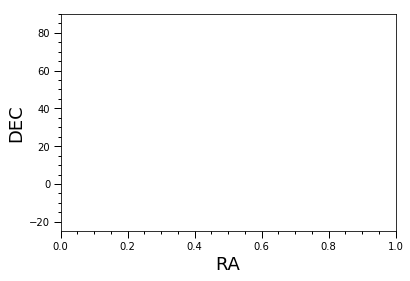

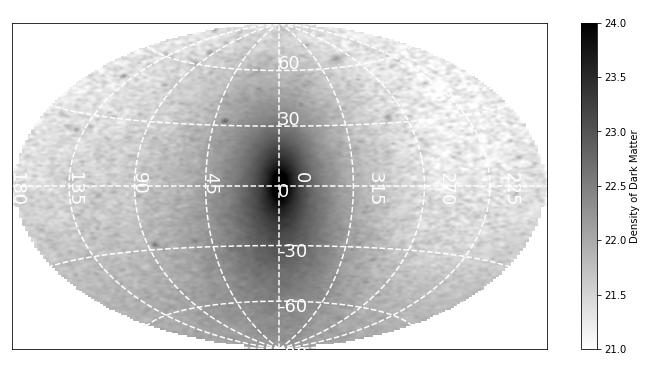

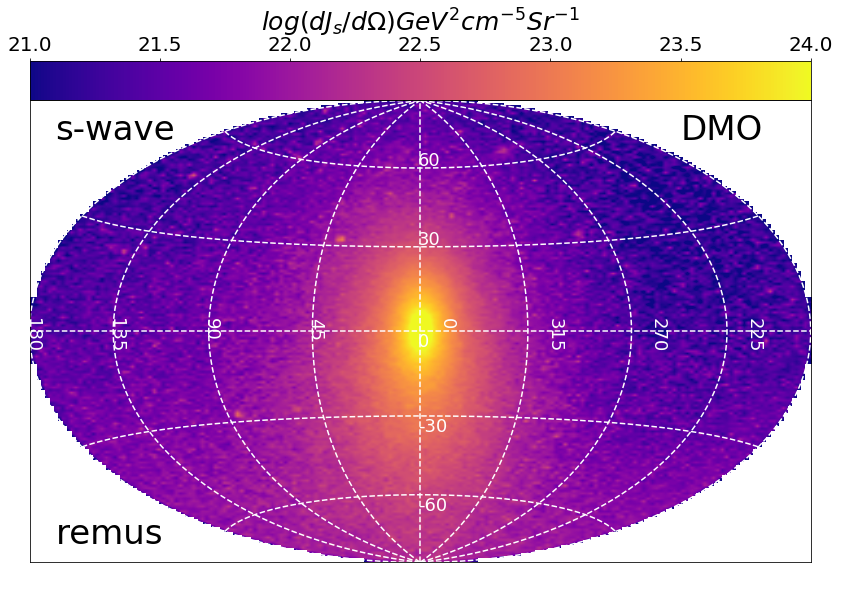

In [52]:
# tested  for 0,180
plot_bins = 180

#r'$R\, [kpc]$'

lower_limit,upper_limit = 21., 24.


title  = r'$ log(dJ_{s} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $' 

    #mpl.pyplot.text( 21.1,19, str(halo)+': S-Wave DMO', fontsize = 17, color = 'black' )

    
    
x_lim = [21.1,21.1 , 23.5]

y_lim = [18, -13, 18]

run_type = 'DMO'

wave_type = 's-wave'


lower_limit,upper_limit = 21, 24

file_name_of_hammer = 'Hammer_dm_only_'


x_bin,y_bin = hammer_projection(Phi_deg_dark_array_s, Theta_deg_dark_array_s ,Angle_weighting_dark_new_s_conv, plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.plasma,title,x_lim, y_lim, run_type,wave_type)

print(x_bin,y_bin)

# Resolution Limit 

In [53]:
print ( np.degrees (np.arctan( 0.4/8.3)) )

2.759107658620273


# Baryonic Analysis

## Baryonic Weighting

In [54]:
plot_bins = 180


rho_local_times_mass_dm_bary = dm_mass_bary_final * rho_b

rho_local_times_mass_dm_bary_F  = ( rho_local_times_mass_dm_bary * conversion ) 

        
 

Phi_bary_s_f, Theta_bary_s_f,radius_bary,  Angle_weighting_bary_new_s_f ,Cos_Psi_bary_s_f = coord_trans( pos_x_bary ,pos_y_bary ,pos_z_bary ,d, rho_local_times_mass_dm_bary_F )


Angle_weighting_bary_new_s_conv_f = Angle_weighting_bary_new_s_f / ( 4.0 * np.pi/  ( plot_bins * plot_bins)) 


# Careful! Don't do the conversion twice !!!!!!!



Theta_deg_bary_array_s_f, Phi_deg_bary_array_s_f  =  Angle_convert( Theta_bary_s_f,Phi_bary_s_f)

In [55]:
print(np.sum(Theta_bary_s_f), np.sum(Phi_bary_s_f))

82844486.91522269 2582293.711348617


/Users/danmckeown/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


179
1.515392389004538e+22
2655831002118564.0
135022818657289.39
-inf
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
printing max value of DJ/DO
24.564005544830565
printing x and y bins


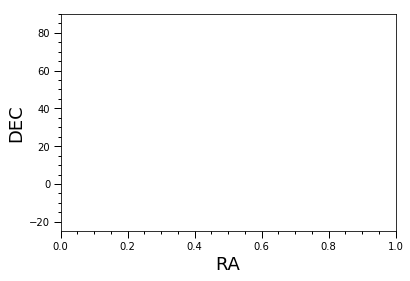

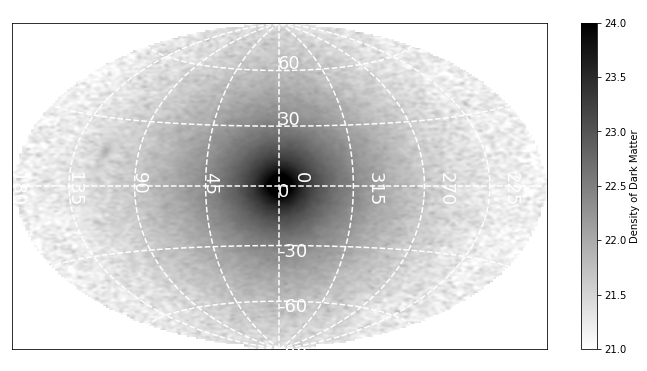

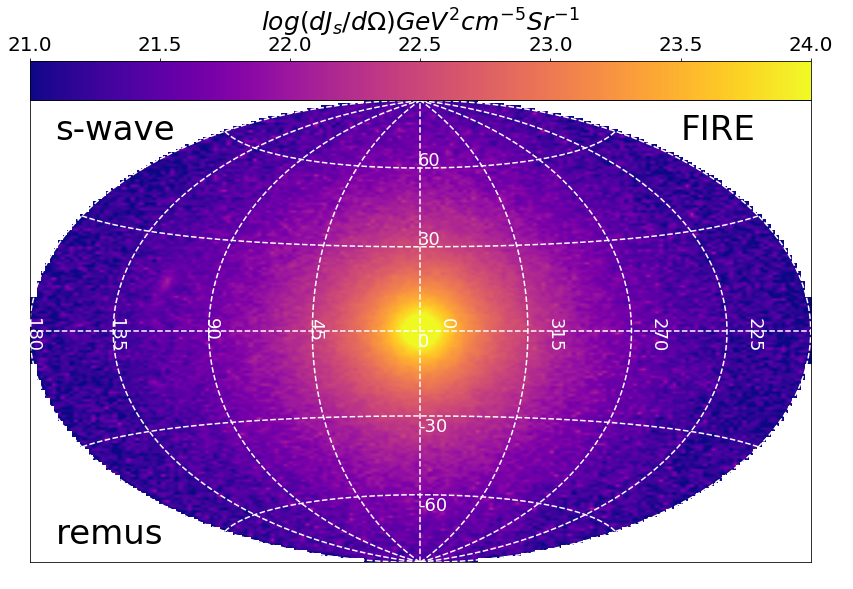

In [56]:
# tested  for 0,180
plot_bins = 180




title  = r'$ log(dJ_{s} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $' 

    #mpl.pyplot.text( 21.1,19, str(halo)+': S-Wave DMO', fontsize = 17, color = 'black' )

    
    
x_lim = [21.1,21.1 , 23.5]

y_lim = [18, -13, 18]

run_type = 'FIRE'

wave_type = 's-wave'


lower_limit,upper_limit = 21, 24

file_name_of_hammer = 'Hammer_bary_only_full_f'




x_bin,y_bin = hammer_projection(Phi_deg_bary_array_s_f, Theta_deg_bary_array_s_f ,Angle_weighting_bary_new_s_conv_f , plot_bins,lower_limit ,upper_limit ,file_name_of_hammer,plt.cm.plasma,title,x_lim, y_lim,run_type, wave_type)

#print(x_bin,y_bin)

# Now interpolate remaining bary radii and combine this vel disp data with Data above to make full weighted array

In [57]:

dispersion_dark_sq = 2.0 * dispersion_dark_basic * dispersion_dark_basic

dispersion_bary_sq = 2.0 * dispersion_bary_basic * dispersion_bary_basic


# Create filename to send 


dm_only_file_name_p_new = '/vel_dm_only_p_wave_leftover'+str(halo)

vel_dm_only_p_wave = local_velocity_disp_weighting_p(dm_only_file_name_p_new, leftover_radii_D,  radial_bins_dark,dispersion_dark_sq)



dark_bary_file_name_p_new = '/vel_bary_p_wave_'+str(halo)

vel_bary_p_wave = local_velocity_disp_weighting_p(dark_bary_file_name_p_new, leftover_radii_B, radial_bins_bary , dispersion_bary_sq)
          

In [58]:
print(len(vel_bary_p_wave))
print(len(vel_dm_only_p_wave))





vel_dm_only_p_wave_short = np.asarray(vel_dm_only_p_wave)
vel_bary_p_wave_short = np.asarray(vel_bary_p_wave)
vel_dm_only_p_wave_short_f = vel_dm_only_p_wave_short/(( 2.99792458e5)**2 )
vel_bary_p_wave_short_f = vel_bary_p_wave_short/(( 2.99792458e5)**2 )

0
0


# Now combine the two velocity disp^2 arrays into one and map it out 

In [59]:
dispersion_dark_sq_Fin = np.asarray(dispersion_dark_sq_F) 

dispersion_bary_sq_Fin = np.asarray(dispersion_bary_sq_F)  


final_dm_p_weight_FINAL = np.concatenate((dispersion_dark_sq_Fin, vel_dm_only_p_wave_short_f))


final_bary_p_weight_FINAL = np.concatenate((dispersion_bary_sq_Fin, vel_bary_p_wave_short_f ))


In [60]:
print(len(vel_dm_only_p_wave_short_f))
print(len(vel_bary_p_wave_short_f))


0
0


In [61]:
print ( np.divide(v_mag_dark_converted    , final_dm_p_weight_FINAL ))

[0.75000106 0.86008359 1.14920089 ... 1.23245796 0.85893546 0.47170156]


In [62]:
final_dm_p_weight_F = final_dm_p_weight_FINAL * rho_local_times_mass_dm_only

plot_bins = 180


final_dm_p_weight_Fin = (  final_dm_p_weight_F * conversion ) 



Phi_dark_p,Theta_dark_p,radius_dark_p,Angle_weighting_dark_p,Cos_Psi_dark_p = coord_trans( pos_x_dark ,pos_y_dark ,pos_z_dark,d, final_dm_p_weight_Fin )


Angle_weighting_dark_p_conv   =   (Angle_weighting_dark_p)  / ( 4. * np.pi /  ( plot_bins * plot_bins)) 

Theta_deg_dark_array_p, Phi_deg_dark_array_p  =  Angle_convert( Theta_dark_p,Phi_dark_p)



/Users/danmckeown/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


179
2.6941718857230196e+16
1360446585.557411
67947969.6119253
-inf
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
printing max value of DJ/DO
18.22778547828529
printing x and y bins


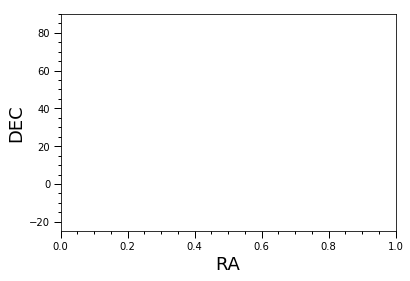

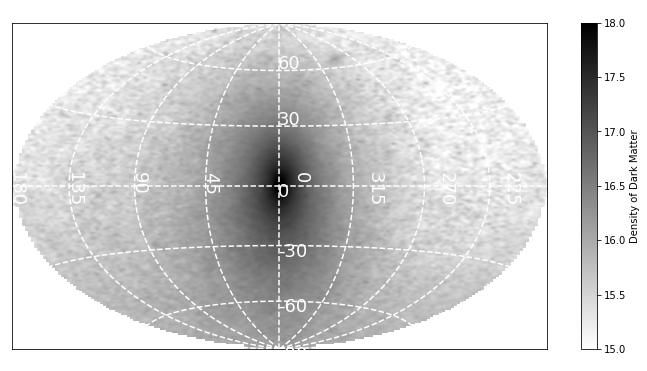

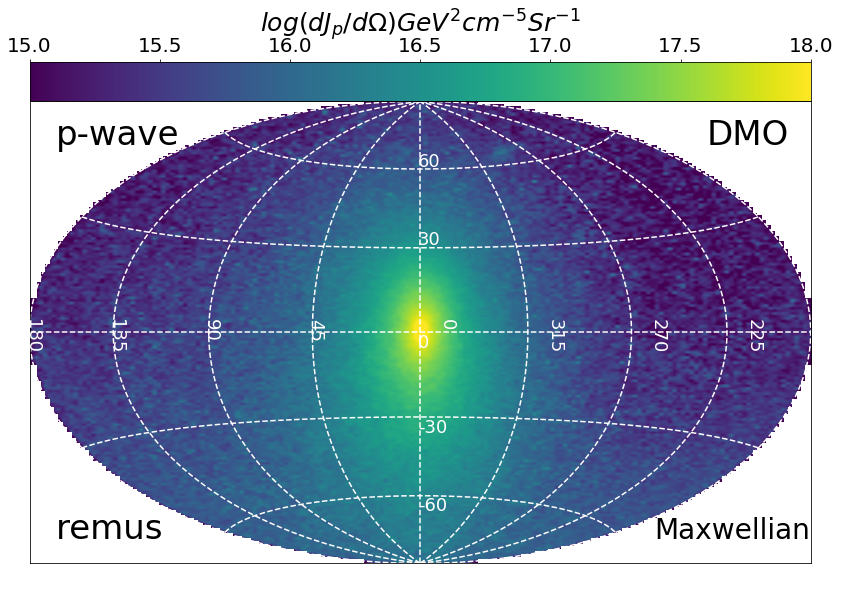

In [63]:
# tested  for 0,180
plot_bins = 180


lower_limit,upper_limit = 15.0, 18

file_name_of_hammer = 'Hammer_dm_only_p_wave_old'


title  = r'$ log(dJ_{p} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $' 



    
x_lim = [15.1, 15.1 , 17.6,17.4]

y_lim = [11.7, -18.6, 11.7]

run_type = 'DMO'

wave_type = 'p-wave'

calc = 'Maxwellian'



x_bin,y_bin = hammer_projection_new(Phi_deg_dark_array_p,Theta_deg_dark_array_p ,Angle_weighting_dark_p_conv, plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.viridis,title, x_lim,y_lim,run_type ,wave_type,calc)

#print(x_bin,y_bin)

In [64]:
plot_bins = 180

final_bary_p_weight_F = final_bary_p_weight_FINAL * rho_local_times_mass_dm_bary

plot_bins = 180


final_bary_p_weight_Fin = (  final_bary_p_weight_F * conversion ) 




Phi_bary_p, Theta_bary_p, radius_bary_p, Angle_weighting_bary_p ,Cos_Psi_bary_p = coord_trans( pos_x_bary ,pos_y_bary ,pos_z_bary,d,final_bary_p_weight_Fin )



Angle_weighting_bary_p_conv = ( Angle_weighting_bary_p)  /  ( 4. * np.pi  /  ( plot_bins * plot_bins)) 


Theta_deg_bary_array_p, Phi_deg_bary_array_p  =  Angle_convert( Theta_bary_p, Phi_bary_p)


/Users/danmckeown/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


179
2.6348334311132304e+16
1083021973.962182
35549547.41611965
-inf
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
printing max value of DJ/DO
18.965017352222016
printing x and y bins


(array([-180.        , -177.98882682, -175.97765363, -173.96648045,
        -171.95530726, -169.94413408, -167.93296089, -165.92178771,
        -163.91061453, -161.89944134, -159.88826816, -157.87709497,
        -155.86592179, -153.8547486 , -151.84357542, -149.83240223,
        -147.82122905, -145.81005587, -143.79888268, -141.7877095 ,
        -139.77653631, -137.76536313, -135.75418994, -133.74301676,
        -131.73184358, -129.72067039, -127.70949721, -125.69832402,
        -123.68715084, -121.67597765, -119.66480447, -117.65363128,
        -115.6424581 , -113.63128492, -111.62011173, -109.60893855,
        -107.59776536, -105.58659218, -103.57541899, -101.56424581,
         -99.55307263,  -97.54189944,  -95.53072626,  -93.51955307,
         -91.50837989,  -89.4972067 ,  -87.48603352,  -85.47486034,
         -83.46368715,  -81.45251397,  -79.44134078,  -77.4301676 ,
         -75.41899441,  -73.40782123,  -71.39664804,  -69.38547486,
         -67.37430168,  -65.36312849,  -63.35195

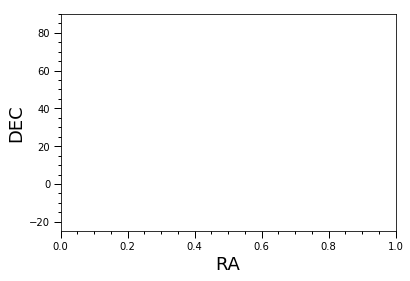

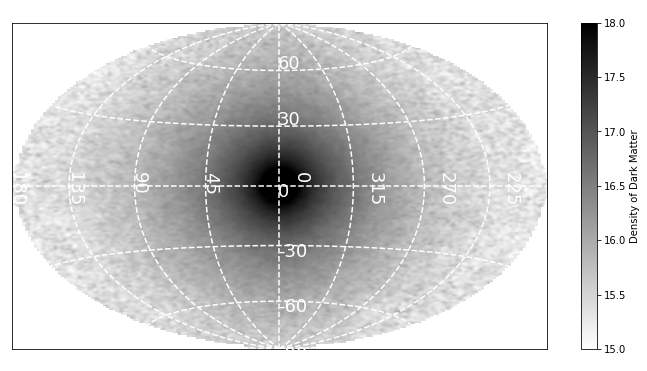

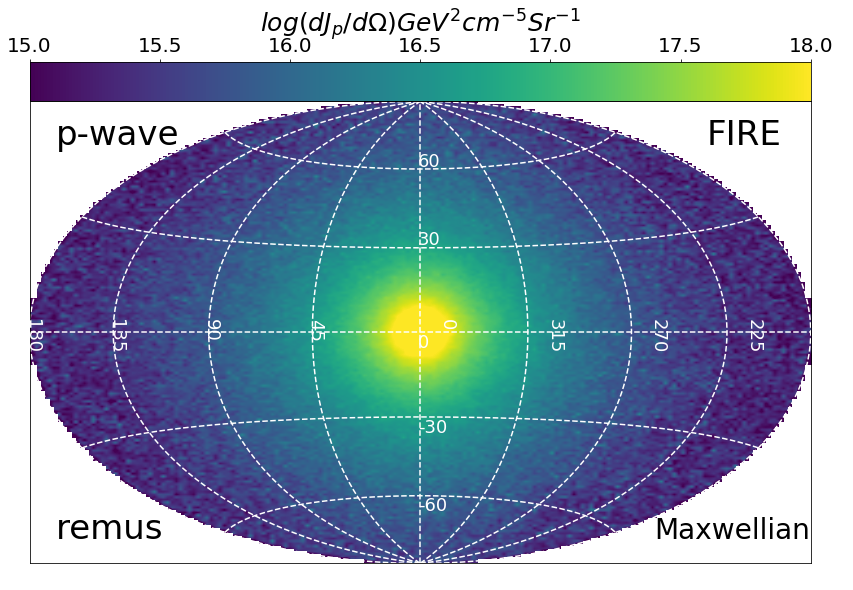

In [65]:
# tested  for 0,180
plot_bins = 180
title = 'p-wave FIRE' + ''+ ' Log(Js}) Gev^2 cm^-5  Sr^{-1}'
lower_limit,upper_limit = 15.0, 18.0



title  = r'$ log(dJ_{p} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $'


x_lim = [15.1, 15.1 , 17.6,17.4]

y_lim = [11.7, -18.6, 11.7]

run_type = 'FIRE'

wave_type = 'p-wave'

calc = 'Maxwellian'


file_name_of_hammer = 'Hammer_bary_p_wave_old'

hammer_projection_new(Phi_deg_bary_array_p,  Theta_deg_bary_array_p,   Angle_weighting_bary_p_conv , plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.viridis,title, x_lim, y_lim,run_type , wave_type,calc)



#print(x_bin,y_bin)

# Now find the same for v_mag **2

In [66]:
v_mag_dark_final_sq = v_mag_dark * v_mag_dark


v_mag_dark_final_sq = (v_mag_dark_final_sq) / (( 2.99792458e5)**2 ) 

In [67]:
final_dm_p_weight_mag = v_mag_dark_final_sq * rho_local_times_mass_dm_only

plot_bins = 180


final_dm_p_weight_mag_F = (  final_dm_p_weight_mag * conversion ) 



Phi_dark_p_mag,Theta_dark_p_mag,radius_dark_p_mag,Angle_weighting_dark_p_mag,Cos_Psi_dark_p_mag = coord_trans( pos_x_dark ,pos_y_dark ,pos_z_dark,d, final_dm_p_weight_mag_F )


Angle_weighting_dark_p_mag_conv   =   (Angle_weighting_dark_p_mag)  / ( 4. * np.pi /  ( plot_bins * plot_bins)) 

Theta_deg_dark_array_p_mag, Phi_deg_dark_array_p_mag  =  Angle_convert( Theta_dark_p_mag,Phi_dark_p_mag)



/Users/danmckeown/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


179
2.6827331292866024e+16
1027951930.1031324
47909761.00492132
-inf
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
printing max value of DJ/DO
18.15760001747196
printing x and y bins


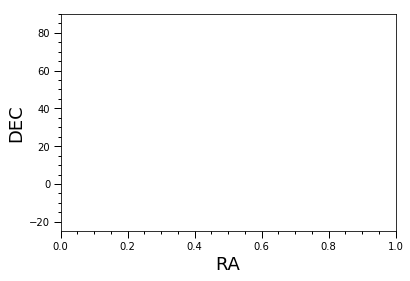

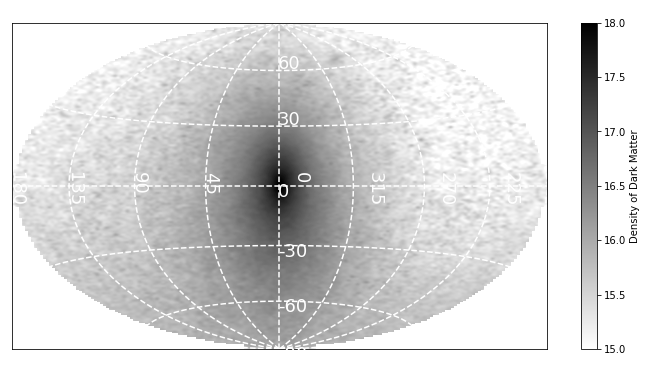

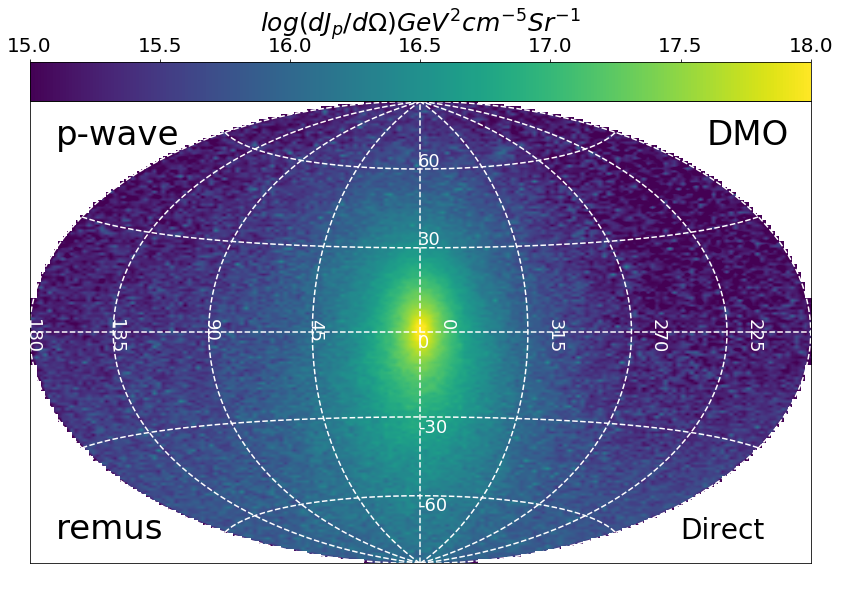

In [68]:
# tested  for 0,180
plot_bins = 180


lower_limit,upper_limit = 15.0, 18

file_name_of_hammer = 'Hammer_dm_only_p_wave_old_mag'


title  = r'$ log(dJ_{p} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $' 



    
x_lim = [15.1, 15.1 , 17.6,17.5]

y_lim = [11.7, -18.6, 11.7]

run_type = 'DMO'

wave_type = 'p-wave'

calc = 'Direct'




x_bin,y_bin = hammer_projection_new(Phi_deg_dark_array_p_mag,Theta_deg_dark_array_p_mag ,Angle_weighting_dark_p_mag_conv, plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.viridis,title, x_lim,y_lim,run_type ,wave_type,calc)

#print(x_bin,y_bin)

In [69]:
v_mag_bary_final_sq = v_mag_bary * v_mag_bary


v_mag_bary_final_sq = (v_mag_bary_final_sq) / (( 2.99792458e5)**2 ) 

In [70]:
final_bary_p_weight_mag = v_mag_bary_final_sq * rho_local_times_mass_dm_bary

plot_bins = 180


final_bary_p_weight_mag_F = (  final_bary_p_weight_mag * conversion ) 



Phi_bary_p_mag,Theta_bary_p_mag,radius_bary_p_mag,Angle_weighting_bary_p_mag,Cos_Psi_bary_p_mag = coord_trans( pos_x_bary ,pos_y_bary ,pos_z_bary,d, final_bary_p_weight_mag_F )


Angle_weighting_bary_p_mag_conv   =   (Angle_weighting_bary_p_mag)  / ( 4. * np.pi /  ( plot_bins * plot_bins)) 

Theta_deg_bary_array_p_mag, Phi_deg_bary_array_p_mag  =  Angle_convert( Theta_bary_p_mag,Phi_bary_p_mag)



/Users/danmckeown/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


179
3.3274700806620496e+16
837517503.0941745
25391306.004691564
-inf
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
printing max value of DJ/DO
18.9130830468223
printing x and y bins


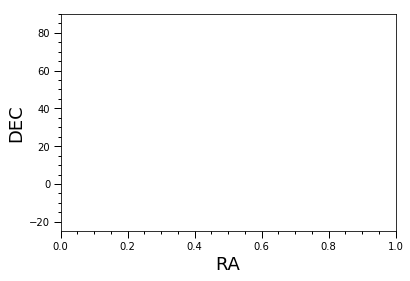

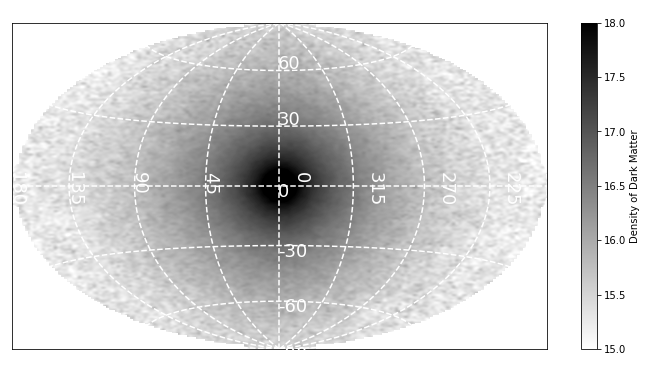

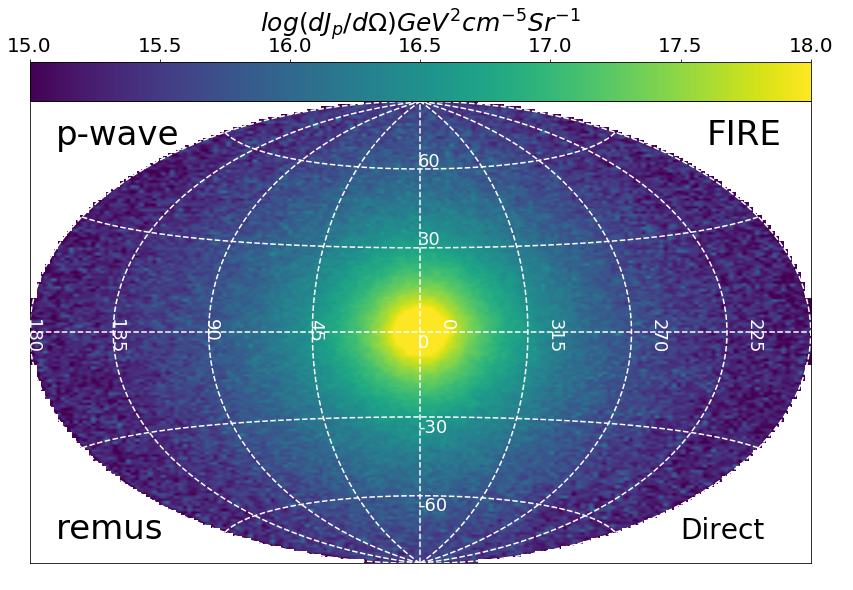

In [71]:
# tested  for 0,180
plot_bins = 180


lower_limit,upper_limit = 15.0, 18

file_name_of_hammer = 'Hammer_bary_p_wave_old_mag'


title  = r'$ log(dJ_{p} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $' 



    
x_lim = [15.1, 15.1 , 17.6,17.5]

y_lim = [11.7, -18.6, 11.7]

run_type = 'FIRE'

wave_type = 'p-wave'

calc = "Direct"



x_bin,y_bin = hammer_projection_new(Phi_deg_bary_array_p_mag,Theta_deg_bary_array_p_mag ,Angle_weighting_bary_p_mag_conv, plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.viridis,title, x_lim,y_lim,run_type ,wave_type,calc)

#print(x_bin,y_bin)

# D Weights

In [72]:

dispersion_dark_4 = (48./9.)* (dispersion_dark_basic)**4 

dispersion_bary_4 = (48./9.)* (dispersion_bary_basic)**4


# Create filename to send 


dm_only_file_name_d_new = '/vel_dm_only_d_wave_leftover'+str(halo)

vel_dm_only_d_wave = local_velocity_disp_weighting_d(dm_only_file_name_d_new, leftover_radii_D,  radial_bins_dark,dispersion_dark_4)



dark_bary_file_name_d_new = '/vel_bary_p_wave_'+str(halo)

vel_bary_d_wave = local_velocity_disp_weighting_d(dark_bary_file_name_d_new, leftover_radii_B, radial_bins_bary , dispersion_bary_4)
          

In [73]:
print(len(vel_bary_d_wave))
print(len(vel_dm_only_d_wave))





vel_dm_only_d_wave_short_4 = np.asarray(vel_dm_only_d_wave)

vel_bary_d_wave_short_4 = np.asarray(vel_bary_d_wave)

vel_dm_only_d_wave_short_f = vel_dm_only_d_wave_short_4/(( 2.99792458e5)**4 )

vel_bary_d_wave_short_f = vel_bary_d_wave_short_4/(( 2.99792458e5)**4 )

0
0


In [74]:

dispersion_dark_4_Fin = np.asarray(dispersion_dark_fourth_F ) 

dispersion_bary_4_Fin = np.asarray(dispersion_bary_fourth_F )  


final_dm_d_weight_FINAL = np.concatenate((dispersion_dark_4_Fin, vel_dm_only_d_wave_short_f))


final_bary_d_weight_FINAL = np.concatenate((dispersion_bary_4_Fin, vel_bary_d_wave_short_f ))


In [75]:
final_dm_d_weight  = ( final_dm_d_weight_FINAL *rho_local_times_mass_dm_only)

plot_bins = 180


final_dm_d_weight_Fin = (  final_dm_d_weight * conversion ) 
  



Phi_dark_d, Theta_dark_d, radius_dark_d, Angle_weighting_dark_d, Cos_Psi_dark_d = coord_trans( pos_x_dark ,pos_y_dark ,pos_z_dark,d, final_dm_d_weight_Fin )


plot_bins = 180


Angle_weighting_dark_new_d_conv = ( Angle_weighting_dark_d )  / ( 4. * np.pi /  ( plot_bins * plot_bins)) 



Theta_deg_dark_array_d, Phi_deg_dark_array_d  =  Angle_convert( Theta_dark_d , Phi_dark_d)







/Users/danmckeown/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


179
44294245921.68689
856.9855780789761
23.698604610486292
-inf
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
printing max value of DJ/DO
11.981941868455678
printing x and y bins


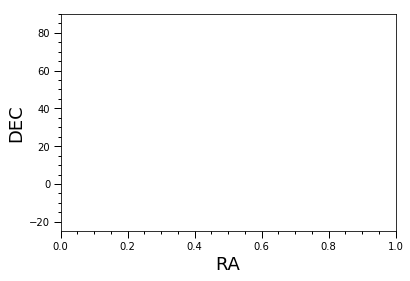

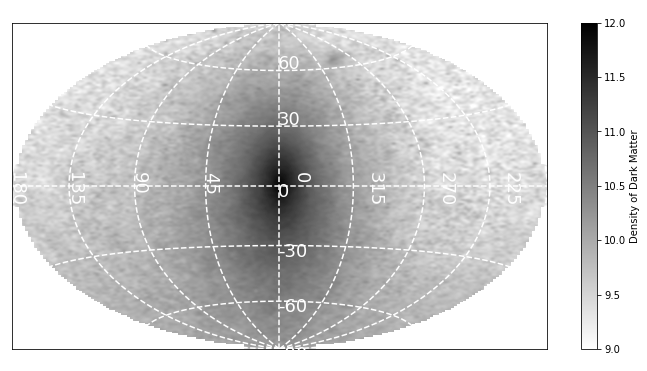

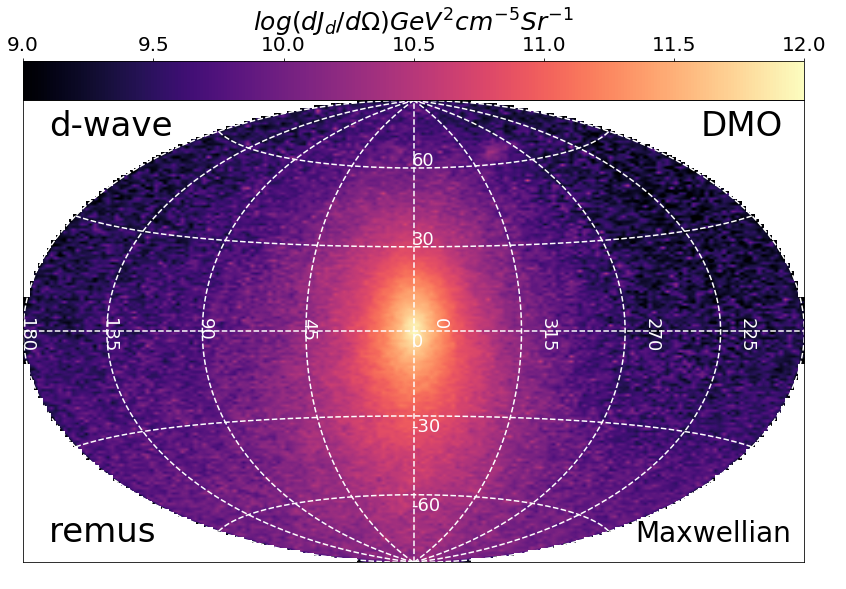

In [76]:
# tested  for 0,180
plot_bins = 180

title  = r'$ log(dJ_{d} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $'





x_lim = [9.1, 9.1 , 11.6,11.35]

y_lim = [6.3, -24.9, 6.3]

run_type = 'DMO'

wave_type = 'd-wave'

calc = "Maxwellian"

lower_limit,upper_limit = 9.0,12.0

file_name_of_hammer = 'hammer_dm_only_'


x_bin,y_bin = hammer_projection_new(Phi_deg_dark_array_d , Theta_deg_dark_array_d ,Angle_weighting_dark_new_d_conv, plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.magma,title,x_lim, y_lim,run_type, wave_type,calc)

#print(x_bin,y_bin)

In [77]:
plot_bins = 180

final_bary_d_weight  = ( final_bary_d_weight_FINAL *rho_local_times_mass_dm_bary)


final_bary_d_weight_Fin =  final_bary_d_weight * conversion   

Phi_bary_d,Theta_bary_d,radius_bary_d,Angle_weighting_bary_d,Cos_Psi_bary_d = coord_trans( pos_x_bary ,pos_y_bary ,pos_z_bary,d, final_bary_d_weight_Fin )



Angle_weighting_bary_new_d_conv = ( Angle_weighting_bary_d   ) /  ( 4 * np.pi/  ( plot_bins * plot_bins)) 
#Angle_weighting_bary_new_dj_do = ( Angle_weighting_bary * conversion )  # /( 4 * np.pi/  ( plot_bins * plot_bins)) 


Theta_deg_bary_array_d, Phi_deg_bary_array_d  =  Angle_convert( Theta_bary_d, Phi_bary_d )


/Users/danmckeown/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


179
61082955591.26718
752.8787114051449
12.259926549913924
-inf
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
printing max value of DJ/DO
13.500658562056365
printing x and y bins


(array([-180.        , -177.98882682, -175.97765363, -173.96648045,
        -171.95530726, -169.94413408, -167.93296089, -165.92178771,
        -163.91061453, -161.89944134, -159.88826816, -157.87709497,
        -155.86592179, -153.8547486 , -151.84357542, -149.83240223,
        -147.82122905, -145.81005587, -143.79888268, -141.7877095 ,
        -139.77653631, -137.76536313, -135.75418994, -133.74301676,
        -131.73184358, -129.72067039, -127.70949721, -125.69832402,
        -123.68715084, -121.67597765, -119.66480447, -117.65363128,
        -115.6424581 , -113.63128492, -111.62011173, -109.60893855,
        -107.59776536, -105.58659218, -103.57541899, -101.56424581,
         -99.55307263,  -97.54189944,  -95.53072626,  -93.51955307,
         -91.50837989,  -89.4972067 ,  -87.48603352,  -85.47486034,
         -83.46368715,  -81.45251397,  -79.44134078,  -77.4301676 ,
         -75.41899441,  -73.40782123,  -71.39664804,  -69.38547486,
         -67.37430168,  -65.36312849,  -63.35195

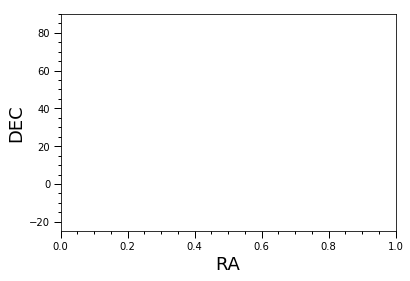

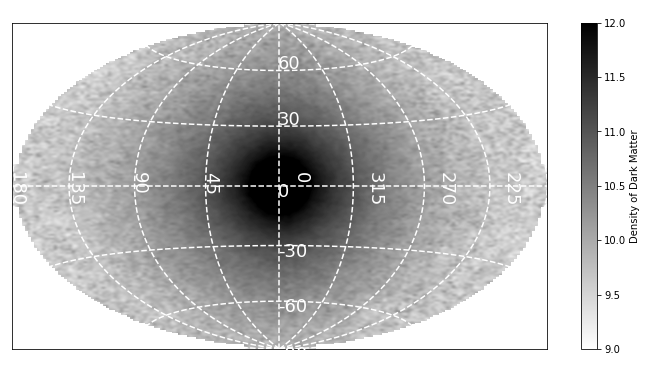

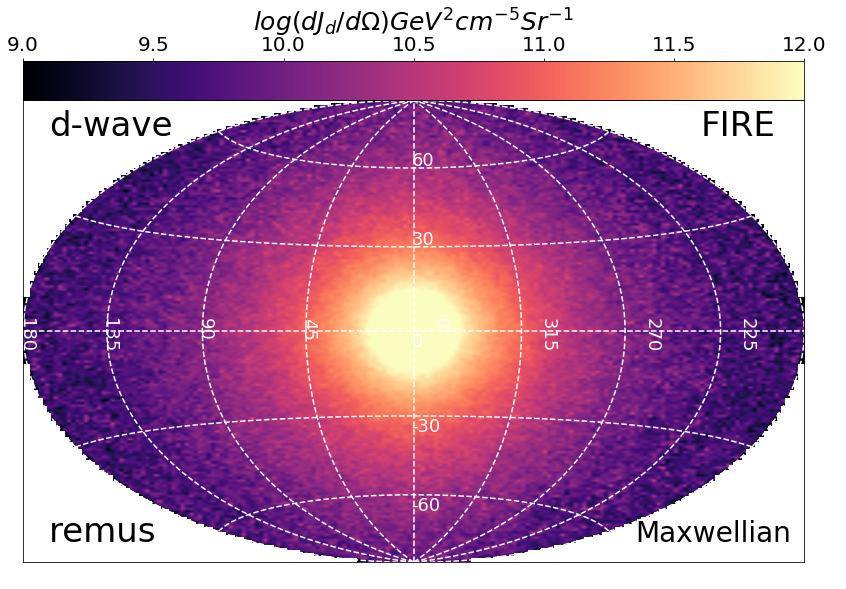

In [78]:
# tested  for 0,180
plot_bins = 180
title  = r'$ log(dJ_{d} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $'

x_lim = [9.1, 9.1 , 11.6,11.35]

y_lim = [6.3, -24.9, 6.3]

run_type = 'FIRE'

wave_type = 'd-wave'

calc = "Maxwellian"


lower_limit,upper_limit = 9, 12

file_name_of_hammer = 'hammer_bary_'


hammer_projection_new(Phi_deg_bary_array_d , Theta_deg_bary_array_d ,   Angle_weighting_bary_new_d_conv , plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.magma,title, x_lim, y_lim,run_type, wave_type,calc)



#print(x_bin,y_bin)


# Now find the same for v_mag **4

In [79]:
v_mag_dark_final_4th = (v_mag_dark)**4


v_mag_dark_final_4th = (v_mag_dark_final_4th) / (( 2.99792458e5)**4 ) 

In [80]:
final_dm_d_weight_mag  = ( v_mag_dark_final_4th *rho_local_times_mass_dm_only)

plot_bins = 180


final_dm_d_weight_Fin_mag = (  final_dm_d_weight_mag * conversion ) 
  



Phi_dark_d_mag, Theta_dark_d_mag, radius_dark_d_mag, Angle_weighting_dark_d_mag, Cos_Psi_dark_d_mag = coord_trans( pos_x_dark ,pos_y_dark ,pos_z_dark,d, final_dm_d_weight_Fin_mag )


plot_bins = 180


Angle_weighting_dark_new_d_conv_mag = ( Angle_weighting_dark_d_mag )  / ( 4. * np.pi /  ( plot_bins * plot_bins)) 



Theta_deg_dark_array_d_mag, Phi_deg_dark_array_d_mag  =  Angle_convert( Theta_dark_d_mag , Phi_dark_d_mag)







/Users/danmckeown/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


179
54879331190.44855
381.62767017309
8.891585143601315
-inf
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
printing max value of DJ/DO
11.927071544134252
printing x and y bins


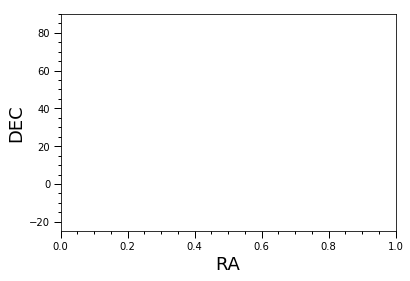

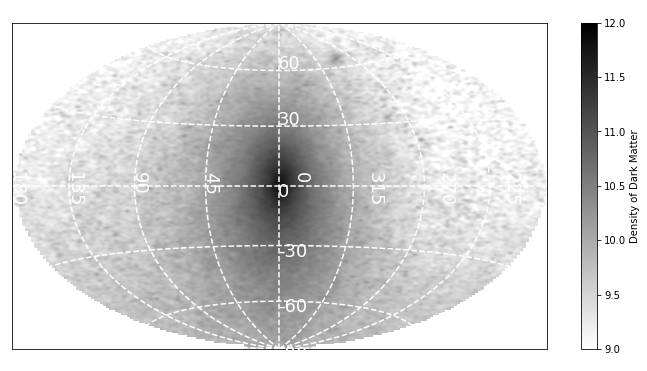

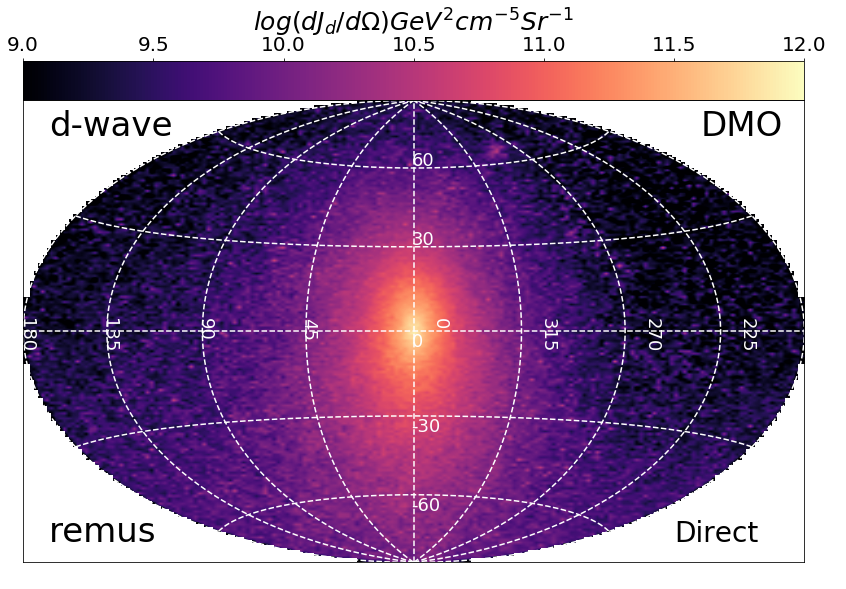

In [81]:
# tested  for 0,180
plot_bins = 180

title  = r'$ log(dJ_{d} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $'





x_lim = [9.1, 9.1 , 11.6,11.5]

y_lim = [6.3, -24.9, 6.3]

run_type = 'DMO'

wave_type = 'd-wave'

calc = "Direct"


lower_limit,upper_limit = 9.0,12.0

file_name_of_hammer = 'hammer_dm_only_mag'


x_bin,y_bin = hammer_projection_new(Phi_deg_dark_array_d_mag , Theta_deg_dark_array_d_mag ,Angle_weighting_dark_new_d_conv_mag, plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.magma,title,x_lim, y_lim,run_type, wave_type,calc)

#print(x_bin,y_bin)

In [82]:
v_mag_bary_final_4th = (v_mag_bary)**4


v_mag_bary_final_4th = (v_mag_bary_final_4th) / (( 2.99792458e5)**4 ) 

In [83]:
final_bary_d_weight_mag  = ( v_mag_bary_final_4th *rho_local_times_mass_dm_bary)

plot_bins = 180


final_bary_d_weight_Fin_mag = (  final_bary_d_weight_mag * conversion ) 
  



Phi_bary_d_mag, Theta_bary_d_mag, radius_bary_d_mag, Angle_weighting_bary_d_mag, Cos_Psi_bary_d_mag = coord_trans( pos_x_bary ,pos_y_bary ,pos_z_bary,d, final_bary_d_weight_Fin_mag )


plot_bins = 180


Angle_weighting_bary_new_d_conv_mag = ( Angle_weighting_bary_d_mag )  / ( 4. * np.pi /  ( plot_bins * plot_bins)) 



Theta_deg_bary_array_d_mag, Phi_deg_bary_array_d_mag  =  Angle_convert( Theta_bary_d_mag , Phi_bary_d_mag)







/Users/danmckeown/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


179
113916712114.71469
347.06343329383634
4.832973116713405
-inf
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
[  0.  45.  90. 135. 180. 225. 270. 315. 360.]
0
45
90
135
180
225
270
315
0
printing max value of DJ/DO
13.337119618981044
printing x and y bins


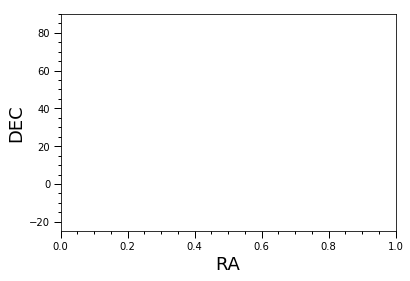

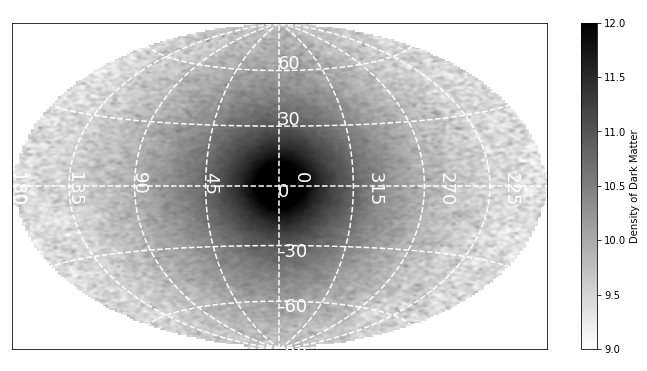

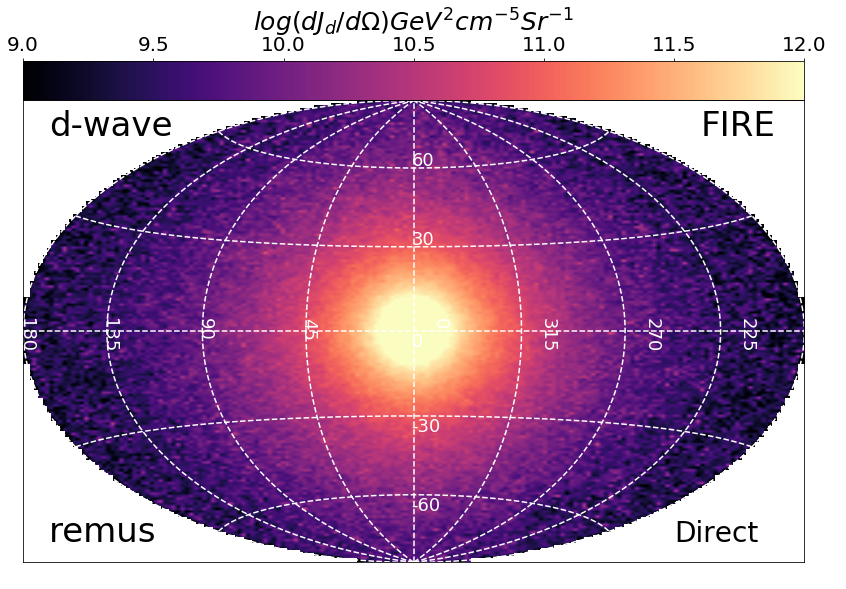

In [84]:
# tested  for 0,180
plot_bins = 180

title  = r'$ log(dJ_{d} /d\Omega) { GeV^{2} cm^{-5} Sr^{-1} } $'





x_lim = [9.1, 9.1 , 11.6,11.5]

y_lim = [6.3, -24.9, 6.3]

run_type = 'FIRE'

wave_type = 'd-wave'
calc = "Direct"


lower_limit,upper_limit = 9.0,12.0

file_name_of_hammer = 'hammer_bary_only_mag'


x_bin,y_bin = hammer_projection_new(Phi_deg_bary_array_d_mag , Theta_deg_bary_array_d_mag ,Angle_weighting_bary_new_d_conv_mag, plot_bins,lower_limit,upper_limit,file_name_of_hammer,plt.cm.magma,title,x_lim, y_lim,run_type, wave_type,calc)

#print(x_bin,y_bin)

# Create J factor Plots for Velocity Independent J factors

# 15).

In [85]:
def J_( Cos_Psi, Final_weights):   
# Cos_Psi is x/r  ( an array of coords)    
    J_bins = 35    

    

    sin_bins = np.logspace( -2.0, 0, J_bins)

    Cos_Psi_bins = np.sqrt(1. - (sin_bins)**2 )


    Cos_Psi_bins_reverse = Cos_Psi_bins[::-1]    
    
    
    #Cos_Psi_bins_reverse = Cos_Psi_bins[::-1]


    J_factor , bin_edges_psi = np.histogram(Cos_Psi,  bins = Cos_Psi_bins_reverse,  weights = Final_weights)
    # Where the particles are, their weights, the bins
    
    print('bin check')
    J_factor_reverse = J_factor[::-1]
    
    print(bin_edges_psi)
    bin_edges_psi_reverse = bin_edges_psi[::-1]
    
    print(Cos_Psi_bins_reverse)
    
    J_factor = np.array(J_factor,dtype=float ) 
        
    
    J_factor_reverse = np.array(J_factor_reverse,dtype=float ) 
    #print('bin edges')
    #print(bin_edges_psi)
    
    bin_edges_psi_final = np.degrees(np.arccos(bin_edges_psi)) 
    
    #bin_edges_psi_final =  bin_edges_psi_final[:-1]
    
    
    bin_edges_psi_final_reverse = bin_edges_psi_final[::-1]
    
    d_theta = np.diff(bin_edges_psi_final_reverse )
    #bin_edges_psi_final_reverse = bin_edges_psi_final_reverse[:-1]
    
    print('printing bins')
    print(bin_edges_psi_final_reverse)
    
    print(len( bin_edges_psi_final  ), len( J_factor))

    J_factor_sum = np.cumsum(J_factor_reverse,axis=0)



    
    return   J_factor, J_factor_reverse,J_factor_sum, bin_edges_psi,bin_edges_psi_reverse, bin_edges_psi_final, bin_edges_psi_final_reverse, d_theta

# 16).

In [86]:

def J_factor_plots( reverse_dark_bins  ,  reverse_bary_bins,  J_factor_dark_sum, J_factor_bary_sum, x_lim, y_lim, wave_type,y_minimum ,y_maximum  ):
 
  
    ax_font = 45
    txt_font = 45
    lw = 4


    fig, ax = plt.subplots(figsize=(15,10))
    ax.tick_params(which='major',width= 3,length=15, direction = 'in', top = True ,right = True, labelsize = ax_font)

    ax.tick_params(which='minor',width= 1.5,length=13, direction = 'in', top = True ,right = True, labelsize = ax_font)

    plt.xlabel(r'$ \, \Psi [deg] $', fontsize = 30)

    plt.ylabel(r'$J (< \Psi) \, [ GEV ^{2} cm^{-5} ]$', fontsize = 30)
  

    mpl.pyplot.text( x_lim,y_lim, str(halo)+':'+ wave_type , fontsize = 30, color = 'black' )

    #plt.semilogy(degree_same, J_factor_sum,color = 'Blue',linewidth= 6,label = "" )
    plt.semilogy(reverse_dark_bins, J_factor_dark_sum,color =  CB_color_cycle[0],linewidth= 6,label = " DMO " )
    plt.semilogy(reverse_bary_bins, J_factor_bary_sum,color =  CB_color_cycle[7],linewidth= 6,label = "FIRE" )
    plt.legend(fontsize = 20)
    #plt.title('Dark Matter Only', fontsize = 30)

    plt.xlim([0,20])
    #plt.ylim ( [10**17 , 10 **25])
    plt.savefig(path +'/J_cumulative'+str(wave_type)+str(halo)+'.png',  bbox_inches='tight' )
    plt.show()



# 17

In [87]:

def J_factor_plots_new( reverse_dark_bins  ,reverse_dark_bins_mag,  reverse_bary_bins, reverse_bary_bins_mag, J_factor_dark_sum, J_factor_dark_sum_mag  , J_factor_bary_sum, J_factor_bary_sum_mag, x_lim, y_lim, wave_type,y_minimum ,y_maximum  ):
 
  
    ax_font = 45
    txt_font = 45
    lw = 4


    fig, ax = plt.subplots(figsize=(15,10))
    ax.tick_params(which='major',width= 3,length=15, direction = 'in', top = True ,right = True, labelsize = ax_font)

    ax.tick_params(which='minor',width= 1.5,length=13, direction = 'in', top = True ,right = True, labelsize = ax_font)

    plt.xlabel(r'$ \, \Psi [deg] $', fontsize = 30)

    plt.ylabel(r'$J (< \Psi) \, [ GEV ^{2} cm^{-5} ]$', fontsize = 30)
  

    mpl.pyplot.text( x_lim,y_lim, str(halo)+':'+ wave_type , fontsize = 30, color = 'black' )

    #plt.semilogy(degree_same, J_factor_sum,color = 'Blue',linewidth= 6,label = "" )
    plt.semilogy(reverse_dark_bins, J_factor_dark_sum,color =  CB_color_cycle[0],linewidth= 6,label = " DMO Maxwellian " )
    plt.semilogy(reverse_bary_bins, J_factor_bary_sum,color =  CB_color_cycle[7],linewidth= 6,label = "FIRE Maxwellian" )
    plt.semilogy(reverse_dark_bins_mag, J_factor_dark_sum_mag,color =  CB_color_cycle[0],linewidth= 3,label = " DMO DIRECT ", linestyle='dashed' )
    plt.semilogy(reverse_bary_bins_mag, J_factor_bary_sum_mag,color =  CB_color_cycle[7],linewidth= 3,label = "FIRE DIRECT" , linestyle='dashed')
    
    
    plt.legend(fontsize = 20)
    #plt.title('Dark Matter Only', fontsize = 30)

    plt.xlim([0,20])
    #plt.ylim ( [10**17 , 10 **25])
    plt.savefig(path +'/J_cumulative'+str(wave_type)+str(halo)+'.png',  bbox_inches='tight' )
    plt.show()


# 18). 

In [88]:
def DJ_plots(d_theta,  bin_edges_psi,  J_factor_reverse):

    d_theta_final=   np.radians((d_theta)) 

    print(len((bin_edges_psi_dark )))


    solid_angle = (  np.diff(bin_edges_psi ) * 2.0 * np.pi )


    solid_angle_r = solid_angle[::-1]


    DJ = (J_factor_reverse / solid_angle_r  )


    DJ_DO_bins = (np.degrees(np.arccos(bin_edges_psi)))

    DJ_DO_bins_final = DJ_DO_bins[::-1]


    DJ_DO_bins_final_final =  (    DJ_DO_bins_final[1:] + DJ_DO_bins_final[:-1]) / 2.0 

    return DJ_DO_bins_final_final , DJ 

# 19).

In [89]:
def DJ_plots_new(d_theta,  bin_edges_psi,  J_factor_reverse):

    d_theta_final=   np.radians((d_theta)) 

    print(len((bin_edges_psi_dark )))


    solid_angle = (  np.diff(bin_edges_psi ) * 2.0 * np.pi )


    solid_angle_r = solid_angle[::-1]


    DJ = (J_factor_reverse / solid_angle_r  )


    DJ_DO_bins = (np.degrees(np.arccos(bin_edges_psi)))

    DJ_DO_bins_final = DJ_DO_bins[::-1]


    DJ_DO_bins_final_final =  (    DJ_DO_bins_final[1:] + DJ_DO_bins_final[:-1]) / 2.0 

    return DJ_DO_bins_final_final , DJ 

# S wave Analysis 

In [90]:
J_factor_dark,J_factor_dark_reverse, J_factor_dark_sum,bin_edges_psi_dark, bin_edges_psi_reverse_dark, bin_edges_psi_final_dark, bin_edges_psi_final_dark_reverse,d_theta_dark  =  J_( Cos_Psi_dark_s, Angle_weighting_dark_new_s )

print(np.min(Cos_Psi_dark_s))


J_factor_bary, J_factor_bary_reverse, J_factor_bary_sum,bin_edges_psi_bary, bin_edges_psi_reverse_bary, bin_edges_psi_final_bary,bin_edges_psi_final_bary_reverse,d_theta_bary =  J_( Cos_Psi_bary_s_f, Angle_weighting_bary_new_s_f)



bin check
[0.         0.48713593 0.6467541  0.74587617 0.81339688 0.86134421
 0.89619086 0.92188336 0.94100757 0.95533627 0.96612191 0.97426784
 0.98043523 0.98511314 0.9886661  0.99136738 0.9934227  0.99498744
 0.99617921 0.99708721 0.99777919 0.99830664 0.99870874 0.99901531
 0.99924906 0.99942731 0.99956324 0.9996669  0.99974596 0.99980625
 0.99985223 0.9998873  0.99991404 0.99993444 0.99995   ]
[0.         0.48713593 0.6467541  0.74587617 0.81339688 0.86134421
 0.89619086 0.92188336 0.94100757 0.95533627 0.96612191 0.97426784
 0.98043523 0.98511314 0.9886661  0.99136738 0.9934227  0.99498744
 0.99617921 0.99708721 0.99777919 0.99830664 0.99870874 0.99901531
 0.99924906 0.99942731 0.99956324 0.9996669  0.99974596 0.99980625
 0.99985223 0.9998873  0.99991404 0.99993444 0.99995   ]
printing bins
[ 0.57296734  0.65607827  0.75124594  0.86022     0.98500434  1.12789411
  1.29151837  1.47888895  1.69345672  1.93917638  2.22058118  2.5428693
  2.91200403  3.33483039  3.81921147  4.3741888

printing dm only bins and J factor sum
[ 0.57296734  0.65607827  0.75124594  0.86022     0.98500434  1.12789411
  1.29151837  1.47888895  1.69345672  1.93917638  2.22058118  2.5428693
  2.91200403  3.33483039  3.81921147  4.37418885  5.01017289  5.73917048
  6.57506102  7.53393581  8.6345225   9.89872742 11.35234501 13.02601201
 14.95653155 17.18877685 19.77854143 22.7970121  26.33819611 30.53215275
 35.57084395 41.76558907 49.70268032 60.84749226]
[3.56121826e+20 8.09764003e+20 1.40046798e+21 2.13550577e+21
 3.10168084e+21 4.24967314e+21 5.65860617e+21 7.47709537e+21
 9.67387655e+21 1.22630242e+22 1.52370054e+22 1.85892157e+22
 2.25827074e+22 2.70998262e+22 3.20893144e+22 3.76961960e+22
 4.35457341e+22 4.98557367e+22 5.67165066e+22 6.38895010e+22
 7.13863890e+22 7.91527782e+22 8.70946012e+22 9.53640647e+22
 1.03655735e+23 1.12030446e+23 1.20485560e+23 1.29019653e+23
 1.37716163e+23 1.46618817e+23 1.55787971e+23 1.65628970e+23
 1.76689785e+23 1.97087834e+23]
printing bary bins and J fa

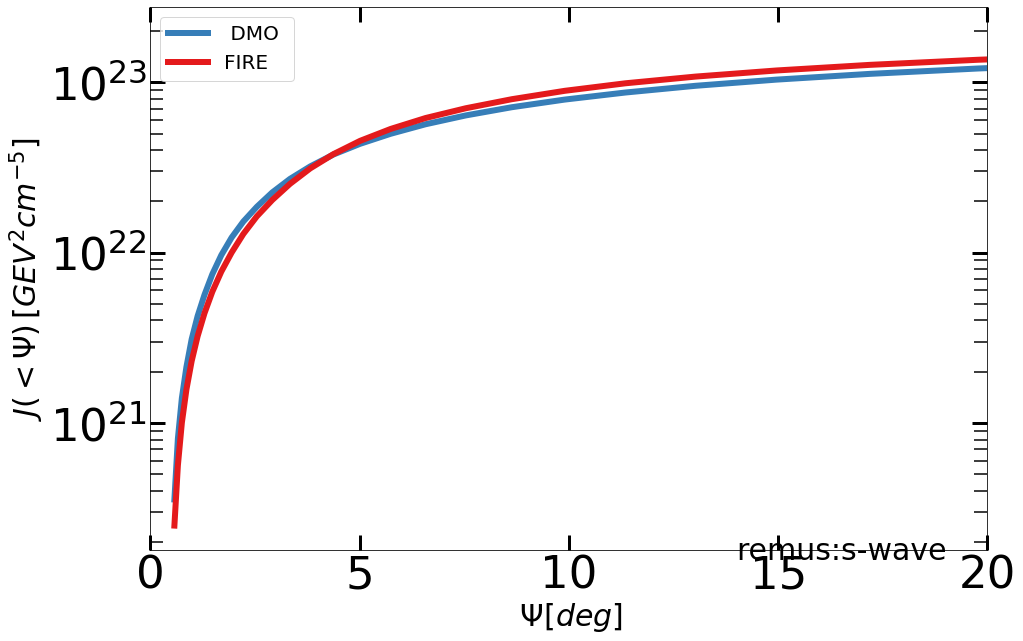

In [91]:
bin_edges_psi_final_dark_reverse_s = bin_edges_psi_final_dark_reverse[:-1]
bin_edges_psi_final_bary_reverse_s = bin_edges_psi_final_bary_reverse[:-1]


y_minimum = 1.0e20 
y_maximum = 5.0e23


x_lim = 14

y_lim = 10**20.2


np.save(path+"/"+'J_factor_dark_sum_s'+str(halo)+'.npy',J_factor_dark_sum)
np.save(path+"/"+'J_factor_bary_sum_s'+str(halo)+'.npy',J_factor_bary_sum)
np.save(path+"/"+'bin_edges_dark_jfactor_sum_s'+str(halo)+'.npy', bin_edges_psi_final_dark_reverse_s)
np.save(path+"/"+'bin_edges_bary_jfactor_sum_s'+str(halo)+'.npy',bin_edges_psi_final_bary_reverse_s) 
        



wave_type = 's-wave'





print('printing dm only bins and J factor sum')
print(bin_edges_psi_final_dark_reverse_s )

print ( J_factor_dark_sum)

print('printing bary bins and J factor sum')
print ( bin_edges_psi_final_bary_reverse_s )


print( J_factor_bary_sum  )


print( J_factor_bary_sum[21])
print(J_factor_dark_sum[21])



J_factor_plots( bin_edges_psi_final_dark_reverse_s, bin_edges_psi_final_bary_reverse_s, J_factor_dark_sum,J_factor_bary_sum,x_lim,y_lim,wave_type,y_minimum ,y_maximum )




In [92]:
DJ_DO_bins_dark_final_final, DJ_dark =   DJ_plots(d_theta_dark ,  bin_edges_psi_dark,  J_factor_dark_reverse)

DJ_DO_bins_bary_final_final, DJ_bary =   DJ_plots(d_theta_bary ,  bin_edges_psi_bary,  J_factor_bary_reverse)


35
35


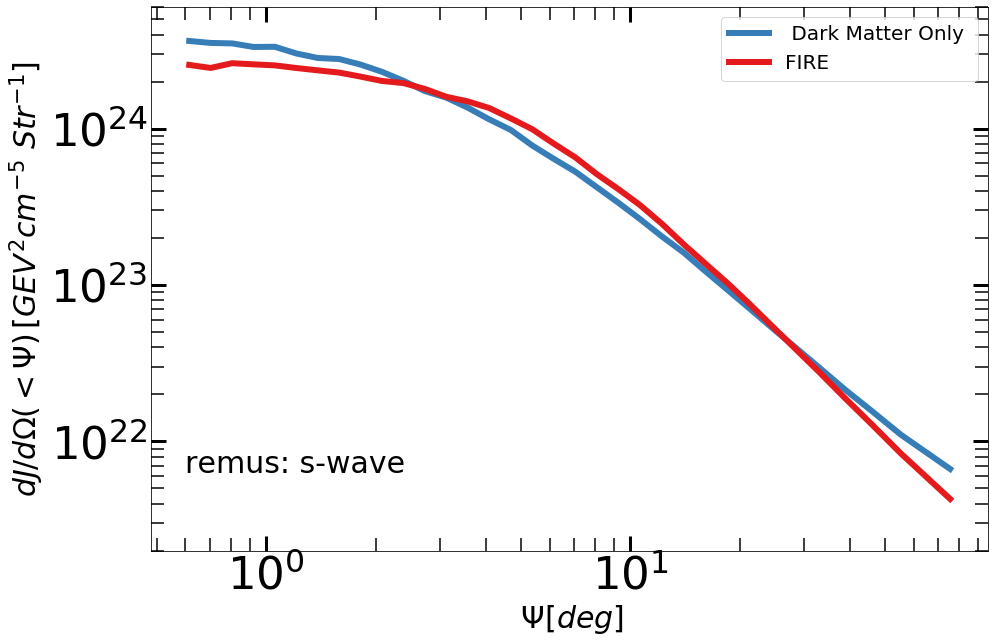

In [93]:
ax_font = 45
txt_font = 45
lw = 4


fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(which='major',width= 3,length=15, direction = 'in', top = True ,right = True, labelsize = ax_font)

ax.tick_params(which='minor',width= 1.5,length=13, direction = 'in', top = True ,right = True, labelsize = ax_font)



plt.loglog(DJ_DO_bins_dark_final_final, DJ_dark ,color =  CB_color_cycle[0],linewidth= 6,label = " Dark Matter Only " )
plt.loglog(DJ_DO_bins_bary_final_final, DJ_bary  ,color =  CB_color_cycle[7],linewidth= 6,label = "FIRE" )

plt.xlabel(r'$ \, \Psi [deg] $', fontsize = 30)

plt.ylabel(r'$ dJ/d \Omega (< \Psi) \, [ GEV ^{2} cm^{-5} \ Str^{-1} ]$', fontsize = 30)
    

plt.legend(fontsize = 20)
    #plt.title('Dark Matter Only', fontsize = 30)

mpl.pyplot.text( 0.6,10**21.8, str(halo)+': s-wave', fontsize = 30, color = 'black' )

 
mpl.pyplot.ylim( y_minimum, y_maximum )

  

y_minimum = 2.0e21 
y_maximum = 6.0e24 

mpl.pyplot.ylim( y_minimum, y_maximum )


np.save(path+"/"+'DJ_DO_bins_s_dark'+str(halo)+'.npy',DJ_DO_bins_dark_final_final)
np.save(path+"/"+'DJ_DO_bins_s_bary'+str(halo)+'.npy',DJ_DO_bins_bary_final_final)
np.save(path+"/"+'DJ_DO_s_dark'+str(halo)+'.npy',DJ_dark)
np.save(path+"/"+'DJ_DO_s_bary'+str(halo)+'.npy',DJ_bary) 
    



plt.savefig(path +'dJ_DO_'+'SWAVE'+str(halo)+'.png',  bbox_inches='tight')


plt.show()

# P wave Analysis 

In [94]:
J_factor_dark_p ,J_factor_dark_reverse_p, J_factor_dark_sum_p   ,bin_edges_psi_dark_p , bin_edges_psi_reverse_dark_p , bin_edges_psi_final_dark_p  , bin_edges_psi_final_dark_reverse_p , d_theta_dark_p  =  J_( Cos_Psi_dark_p, Angle_weighting_dark_p )

print(np.min(Cos_Psi_dark_p))


J_factor_bary_p, J_factor_bary_reverse_p ,   J_factor_bary_sum_p , bin_edges_psi_bary_p  , bin_edges_psi_reverse_bary_p  ,   bin_edges_psi_final_bary_p  ,  bin_edges_psi_final_bary_reverse_p ,  d_theta_bary_p =  J_(Cos_Psi_bary_p ,  Angle_weighting_bary_p )



bin check
[0.         0.48713593 0.6467541  0.74587617 0.81339688 0.86134421
 0.89619086 0.92188336 0.94100757 0.95533627 0.96612191 0.97426784
 0.98043523 0.98511314 0.9886661  0.99136738 0.9934227  0.99498744
 0.99617921 0.99708721 0.99777919 0.99830664 0.99870874 0.99901531
 0.99924906 0.99942731 0.99956324 0.9996669  0.99974596 0.99980625
 0.99985223 0.9998873  0.99991404 0.99993444 0.99995   ]
[0.         0.48713593 0.6467541  0.74587617 0.81339688 0.86134421
 0.89619086 0.92188336 0.94100757 0.95533627 0.96612191 0.97426784
 0.98043523 0.98511314 0.9886661  0.99136738 0.9934227  0.99498744
 0.99617921 0.99708721 0.99777919 0.99830664 0.99870874 0.99901531
 0.99924906 0.99942731 0.99956324 0.9996669  0.99974596 0.99980625
 0.99985223 0.9998873  0.99991404 0.99993444 0.99995   ]
printing bins
[ 0.57296734  0.65607827  0.75124594  0.86022     0.98500434  1.12789411
  1.29151837  1.47888895  1.69345672  1.93917638  2.22058118  2.5428693
  2.91200403  3.33483039  3.81921147  4.3741888

#### now for abs velocity versions

In [95]:
J_factor_dark_p_mag ,J_factor_dark_reverse_p_mag, J_factor_dark_sum_p_mag   ,bin_edges_psi_dark_p_mag , bin_edges_psi_reverse_dark_p_mag , bin_edges_psi_final_dark_p_mag  , bin_edges_psi_final_dark_reverse_p_mag , d_theta_dark_p_mag  =  J_( Cos_Psi_dark_p_mag, Angle_weighting_dark_p_mag )

print(np.min(Cos_Psi_dark_p))


J_factor_bary_p_mag, J_factor_bary_reverse_p_mag ,   J_factor_bary_sum_p_mag , bin_edges_psi_bary_p_mag  , bin_edges_psi_reverse_bary_p_mag  ,   bin_edges_psi_final_bary_p_mag  ,  bin_edges_psi_final_bary_reverse_p_mag ,  d_theta_bary_p_mag =  J_(Cos_Psi_bary_p_mag ,  Angle_weighting_bary_p_mag )



bin check
[0.         0.48713593 0.6467541  0.74587617 0.81339688 0.86134421
 0.89619086 0.92188336 0.94100757 0.95533627 0.96612191 0.97426784
 0.98043523 0.98511314 0.9886661  0.99136738 0.9934227  0.99498744
 0.99617921 0.99708721 0.99777919 0.99830664 0.99870874 0.99901531
 0.99924906 0.99942731 0.99956324 0.9996669  0.99974596 0.99980625
 0.99985223 0.9998873  0.99991404 0.99993444 0.99995   ]
[0.         0.48713593 0.6467541  0.74587617 0.81339688 0.86134421
 0.89619086 0.92188336 0.94100757 0.95533627 0.96612191 0.97426784
 0.98043523 0.98511314 0.9886661  0.99136738 0.9934227  0.99498744
 0.99617921 0.99708721 0.99777919 0.99830664 0.99870874 0.99901531
 0.99924906 0.99942731 0.99956324 0.9996669  0.99974596 0.99980625
 0.99985223 0.9998873  0.99991404 0.99993444 0.99995   ]
printing bins
[ 0.57296734  0.65607827  0.75124594  0.86022     0.98500434  1.12789411
  1.29151837  1.47888895  1.69345672  1.93917638  2.22058118  2.5428693
  2.91200403  3.33483039  3.81921147  4.3741888

printing dm only bins and J factor sum
[ 0.57296734  0.65607827  0.75124594  0.86022     0.98500434  1.12789411
  1.29151837  1.47888895  1.69345672  1.93917638  2.22058118  2.5428693
  2.91200403  3.33483039  3.81921147  4.37418885  5.01017289  5.73917048
  6.57506102  7.53393581  8.6345225   9.89872742 11.35234501 13.02601201
 14.95653155 17.18877685 19.77854143 22.7970121  26.33819611 30.53215275
 35.57084395 41.76558907 49.70268032 60.84749226]
[1.15908921e+14 2.69432461e+14 4.76364871e+14 7.38224211e+14
 1.08947604e+15 1.51076611e+15 2.03175803e+15 2.73427163e+15
 3.61081700e+15 4.68575934e+15 5.96172177e+15 7.45403526e+15
 9.32936634e+15 1.15383822e+16 1.40925753e+16 1.71661207e+16
 2.05461923e+16 2.43576942e+16 2.87376602e+16 3.35572754e+16
 3.88370581e+16 4.45651549e+16 5.07016955e+16 5.73628945e+16
 6.42327547e+16 7.14292509e+16 7.88150070e+16 8.64468348e+16
 9.42900932e+16 1.02438597e+17 1.10966189e+17 1.20075319e+17
 1.30464312e+17 1.49394682e+17]
printing bary bins and J fa

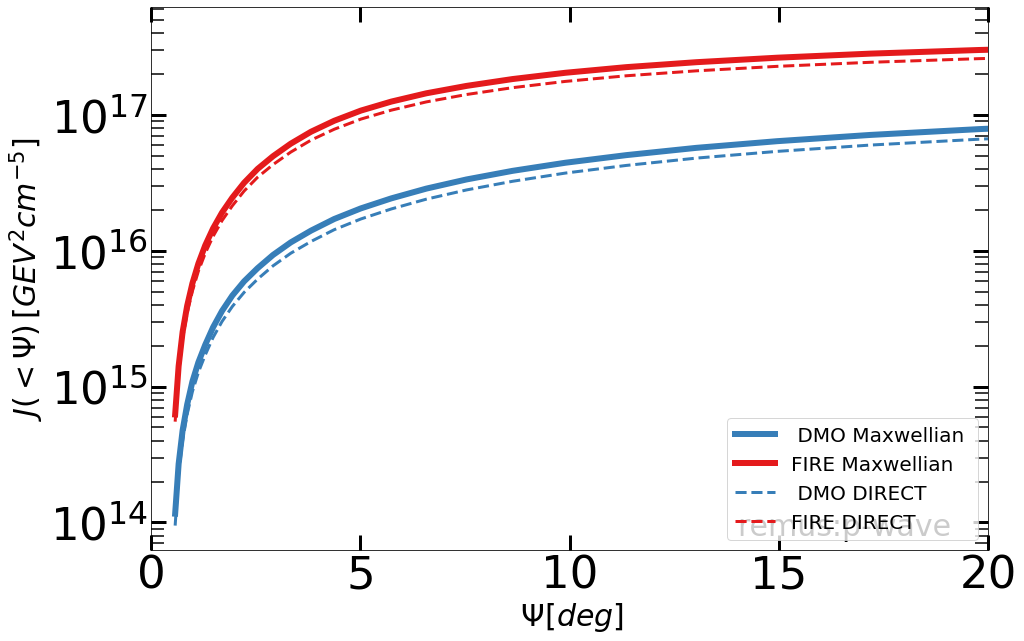

In [96]:
bin_edges_psi_final_dark_reverse_p_final = bin_edges_psi_final_dark_reverse_p[:-1]
bin_edges_psi_final_bary_reverse_p_final = bin_edges_psi_final_bary_reverse_p[:-1]

### mags below

bin_edges_psi_final_dark_reverse_p_final_mag = bin_edges_psi_final_dark_reverse_p_mag[:-1]
bin_edges_psi_final_bary_reverse_p_final_mag = bin_edges_psi_final_bary_reverse_p_mag[:-1]



np.save(path+"/"+'J_factor_dark_sum_p'+str(halo)+'.npy',J_factor_dark_sum_p)
np.save(path+"/"+'J_factor_bary_sum_p'+str(halo)+'.npy',J_factor_bary_sum_p)
np.save(path+"/"+'bin_edges_dark_jfactor_sum_p'+str(halo)+'.npy', bin_edges_psi_final_dark_reverse_p_final)
np.save(path+"/"+'bin_edges_bary_jfactor_sum_p'+str(halo)+'.npy',bin_edges_psi_final_bary_reverse_p_final) 
        

    
# mags below

np.save(path+"/"+'J_factor_dark_sum_p_mag'+str(halo)+'.npy',J_factor_dark_sum_p_mag)
np.save(path+"/"+'J_factor_bary_sum_p_mag'+str(halo)+'.npy',J_factor_bary_sum_p_mag)
np.save(path+"/"+'bin_edges_dark_jfactor_sum_p_mag'+str(halo)+'.npy', bin_edges_psi_final_dark_reverse_p_final_mag)
np.save(path+"/"+'bin_edges_bary_jfactor_sum_p_mag'+str(halo)+'.npy',bin_edges_psi_final_bary_reverse_p_final_mag) 
        


x_lim = 14

y_lim = 10**13.9



wave_type = 'p-wave'


y_minimum = 1.0e13 
y_maximum = 5.0e17

     

print('printing dm only bins and J factor sum')
print(bin_edges_psi_final_dark_reverse_p_final )

print ( J_factor_dark_sum_p)

print('printing bary bins and J factor sum')
print ( bin_edges_psi_final_bary_reverse_p_final )


print( J_factor_bary_sum_p  )


print( J_factor_bary_sum_p[21])
print(J_factor_dark_sum_p[21])






J_factor_plots_new( bin_edges_psi_final_dark_reverse_p_final,bin_edges_psi_final_dark_reverse_p_final_mag, bin_edges_psi_final_bary_reverse_p_final,bin_edges_psi_final_bary_reverse_p_final_mag, J_factor_dark_sum_p ,J_factor_dark_sum_p_mag, J_factor_bary_sum_p, J_factor_bary_sum_p_mag, x_lim,y_lim,wave_type,y_minimum,y_maximum )


In [97]:
DJ_DO_bins_dark_final_final_p, DJ_dark_p =   DJ_plots(d_theta_dark_p ,  bin_edges_psi_dark_p,  J_factor_dark_reverse_p)

DJ_DO_bins_bary_final_final_p, DJ_bary_p =   DJ_plots(d_theta_bary_p ,  bin_edges_psi_bary_p ,  J_factor_bary_reverse_p)


35
35


In [98]:
DJ_DO_bins_dark_final_final_p_mag, DJ_dark_p_mag =   DJ_plots(d_theta_dark_p_mag ,  bin_edges_psi_dark_p_mag,  J_factor_dark_reverse_p_mag)

DJ_DO_bins_bary_final_final_p_mag, DJ_bary_p_mag =   DJ_plots(d_theta_bary_p_mag,  bin_edges_psi_bary_p_mag ,  J_factor_bary_reverse_p_mag)


35
35


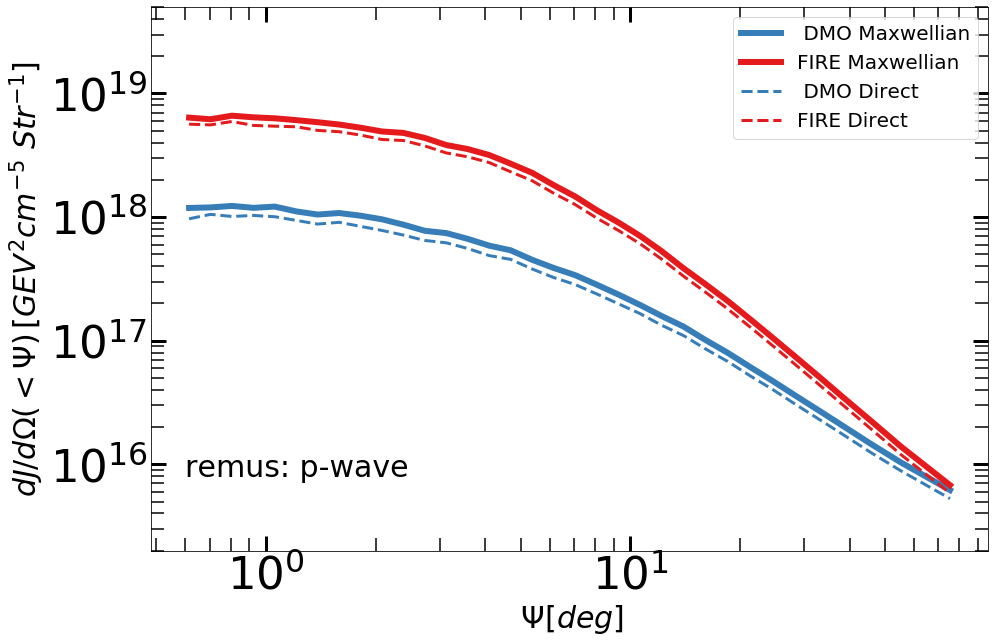

In [99]:
ax_font = 45
txt_font = 45
lw = 4


fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(which='major',width= 3,length=15, direction = 'in', top = True ,right = True, labelsize = ax_font)

ax.tick_params(which='minor',width= 1.5,length=13, direction = 'in', top = True ,right = True, labelsize = ax_font)

plt.xlabel(r'$ \, \Psi [deg] $', fontsize = 30)

plt.ylabel(r'$dJ/d \Omega (< \Psi) \, [ GEV ^{2} cm^{-5} \ Str^{-1} ]$', fontsize = 30)
    

plt.loglog(DJ_DO_bins_dark_final_final_p, DJ_dark_p ,color =  CB_color_cycle[0],linewidth= 6,label = " DMO Maxwellian" )
plt.loglog(DJ_DO_bins_bary_final_final_p, DJ_bary_p  ,color =  CB_color_cycle[7],linewidth= 6,label = "FIRE Maxwellian" )
# MAG
plt.loglog(DJ_DO_bins_dark_final_final_p_mag, DJ_dark_p_mag ,color =  CB_color_cycle[0],linewidth= 3,label = " DMO Direct",  linestyle='dashed' )
plt.loglog(DJ_DO_bins_bary_final_final_p_mag, DJ_bary_p_mag  ,color =  CB_color_cycle[7],linewidth= 3,label = "FIRE Direct",  linestyle='dashed'  )




plt.legend(fontsize = 20)
    #plt.title('Dark Matter Only', fontsize = 30)

mpl.pyplot.text( 0.6,10**15.9, str(halo)+': p-wave', fontsize = 30, color = 'black' )

y_minimum = 2.0e15
y_maximum = 5.0e19  

mpl.pyplot.ylim( y_minimum, y_maximum )

        
np.save(path+"/"+'DJ_DO_bins_p_dark'+str(halo)+'.npy',DJ_DO_bins_dark_final_final_p)
np.save(path+"/"+'DJ_DO_bins_p_bary'+str(halo)+'.npy',DJ_DO_bins_bary_final_final_p)
np.save(path+"/"+'DJ_DO_p_dark'+str(halo)+'.npy',DJ_dark_p)
np.save(path+"/"+'DJ_DO_p_bary'+str(halo)+'.npy',DJ_bary_p)
# MAG
np.save(path+"/"+'DJ_DO_bins_p_dark_mag'+str(halo)+'.npy',DJ_DO_bins_dark_final_final_p_mag)
np.save(path+"/"+'DJ_DO_bins_p_bary_mag'+str(halo)+'.npy',DJ_DO_bins_bary_final_final_p_mag)
np.save(path+"/"+'DJ_DO_p_dark_mag'+str(halo)+'.npy',DJ_dark_p_mag)
np.save(path+"/"+'DJ_DO_p_bary_mag'+str(halo)+'.npy',DJ_bary_p_mag)
        
    
plt.savefig(path +'dJ_DO_'+'PWAVE'+str(halo)+'.png',  bbox_inches='tight') 
    
plt.show()

# D Wave Analysis

In [100]:
J_factor_dark_d ,J_factor_dark_reverse_d, J_factor_dark_sum_d   ,bin_edges_psi_dark_d , bin_edges_psi_reverse_dark_d , bin_edges_psi_final_dark_d  , bin_edges_psi_final_dark_reverse_d , d_theta_dark_d  =  J_( Cos_Psi_dark_d, Angle_weighting_dark_d )

print(np.min(Cos_Psi_dark_d))


J_factor_bary_d, J_factor_bary_reverse_d ,   J_factor_bary_sum_d , bin_edges_psi_bary_d  , bin_edges_psi_reverse_bary_d  ,   bin_edges_psi_final_bary_d  ,  bin_edges_psi_final_bary_reverse_d ,  d_theta_bary_d =  J_(Cos_Psi_bary_d ,  Angle_weighting_bary_d )








bin check
[0.         0.48713593 0.6467541  0.74587617 0.81339688 0.86134421
 0.89619086 0.92188336 0.94100757 0.95533627 0.96612191 0.97426784
 0.98043523 0.98511314 0.9886661  0.99136738 0.9934227  0.99498744
 0.99617921 0.99708721 0.99777919 0.99830664 0.99870874 0.99901531
 0.99924906 0.99942731 0.99956324 0.9996669  0.99974596 0.99980625
 0.99985223 0.9998873  0.99991404 0.99993444 0.99995   ]
[0.         0.48713593 0.6467541  0.74587617 0.81339688 0.86134421
 0.89619086 0.92188336 0.94100757 0.95533627 0.96612191 0.97426784
 0.98043523 0.98511314 0.9886661  0.99136738 0.9934227  0.99498744
 0.99617921 0.99708721 0.99777919 0.99830664 0.99870874 0.99901531
 0.99924906 0.99942731 0.99956324 0.9996669  0.99974596 0.99980625
 0.99985223 0.9998873  0.99991404 0.99993444 0.99995   ]
printing bins
[ 0.57296734  0.65607827  0.75124594  0.86022     0.98500434  1.12789411
  1.29151837  1.47888895  1.69345672  1.93917638  2.22058118  2.5428693
  2.91200403  3.33483039  3.81921147  4.3741888

### now for abs versions

In [101]:
J_factor_dark_d_mag ,J_factor_dark_reverse_d_mag, J_factor_dark_sum_d_mag   ,bin_edges_psi_dark_d_mag , bin_edges_psi_reverse_dark_d_mag , bin_edges_psi_final_dark_d_mag  , bin_edges_psi_final_dark_reverse_d_mag , d_theta_dark_d_mag  =  J_( Cos_Psi_dark_d_mag, Angle_weighting_dark_d_mag )

print(np.min(Cos_Psi_dark_d))


J_factor_bary_d_mag, J_factor_bary_reverse_d_mag ,   J_factor_bary_sum_d_mag , bin_edges_psi_bary_d_mag  , bin_edges_psi_reverse_bary_d_mag  ,   bin_edges_psi_final_bary_d_mag  ,  bin_edges_psi_final_bary_reverse_d_mag ,  d_theta_bary_d_mag =  J_(Cos_Psi_bary_d_mag ,  Angle_weighting_bary_d_mag )



bin check
[0.         0.48713593 0.6467541  0.74587617 0.81339688 0.86134421
 0.89619086 0.92188336 0.94100757 0.95533627 0.96612191 0.97426784
 0.98043523 0.98511314 0.9886661  0.99136738 0.9934227  0.99498744
 0.99617921 0.99708721 0.99777919 0.99830664 0.99870874 0.99901531
 0.99924906 0.99942731 0.99956324 0.9996669  0.99974596 0.99980625
 0.99985223 0.9998873  0.99991404 0.99993444 0.99995   ]
[0.         0.48713593 0.6467541  0.74587617 0.81339688 0.86134421
 0.89619086 0.92188336 0.94100757 0.95533627 0.96612191 0.97426784
 0.98043523 0.98511314 0.9886661  0.99136738 0.9934227  0.99498744
 0.99617921 0.99708721 0.99777919 0.99830664 0.99870874 0.99901531
 0.99924906 0.99942731 0.99956324 0.9996669  0.99974596 0.99980625
 0.99985223 0.9998873  0.99991404 0.99993444 0.99995   ]
printing bins
[ 0.57296734  0.65607827  0.75124594  0.86022     0.98500434  1.12789411
  1.29151837  1.47888895  1.69345672  1.93917638  2.22058118  2.5428693
  2.91200403  3.33483039  3.81921147  4.3741888

printing dm only bins and J factor sum
[ 0.57296734  0.65607827  0.75124594  0.86022     0.98500434  1.12789411
  1.29151837  1.47888895  1.69345672  1.93917638  2.22058118  2.5428693
  2.91200403  3.33483039  3.81921147  4.37418885  5.01017289  5.73917048
  6.57506102  7.53393581  8.6345225   9.89872742 11.35234501 13.02601201
 14.95653155 17.18877685 19.77854143 22.7970121  26.33819611 30.53215275
 35.57084395 41.76558907 49.70268032 60.84749226]
[6.07370127e+07 1.42619608e+08 2.56166921e+08 4.06981034e+08
 6.07157504e+08 8.48610740e+08 1.15186778e+09 1.57723246e+09
 2.12134274e+09 2.80912308e+09 3.64468980e+09 4.64820114e+09
 5.96213211e+09 7.56698671e+09 9.49249162e+09 1.19436029e+10
 1.47660051e+10 1.80739670e+10 2.20536615e+10 2.66315564e+10
 3.18923741e+10 3.78271404e+10 4.44538103e+10 5.19316951e+10
 5.98428676e+10 6.84253054e+10 7.73742623e+10 8.68485770e+10
 9.66791166e+10 1.07065438e+11 1.18083333e+11 1.29924327e+11
 1.43500206e+11 1.67953712e+11]
printing bary bins and J fa

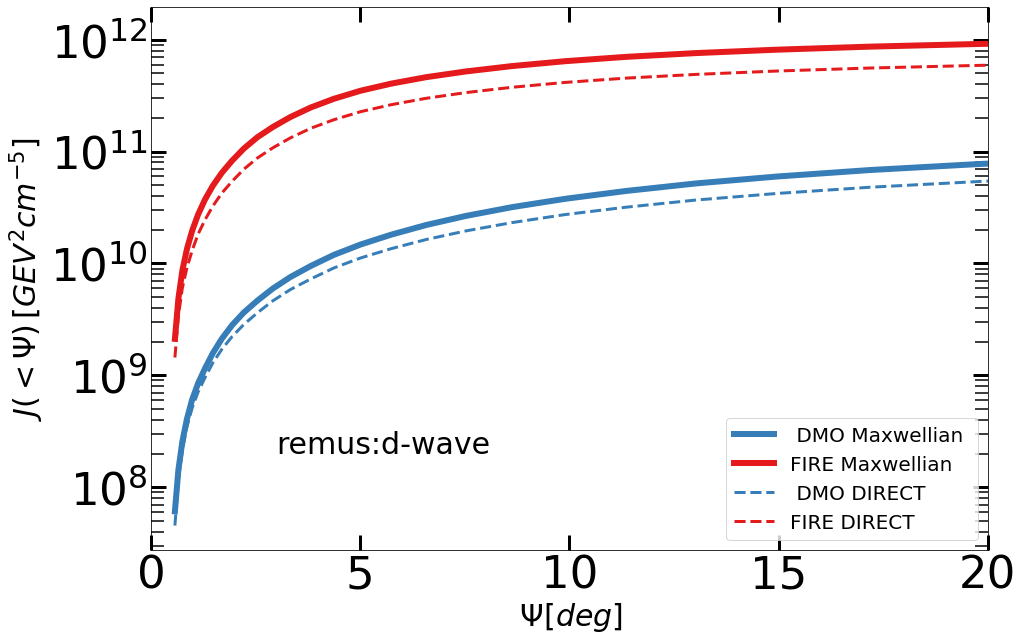

In [102]:
bin_edges_psi_final_dark_reverse_d_final = bin_edges_psi_final_dark_reverse_d[:-1]
bin_edges_psi_final_bary_reverse_d_final = bin_edges_psi_final_bary_reverse_d[:-1]

### mags below

bin_edges_psi_final_dark_reverse_d_final_mag = bin_edges_psi_final_dark_reverse_d_mag[:-1]
bin_edges_psi_final_bary_reverse_d_final_mag = bin_edges_psi_final_bary_reverse_d_mag[:-1]




x_lim = 3

y_lim = 10**8.3

wave_type = 'd-wave'


y_minimum = 1.0e8
y_maximum = 1.0e13


np.save(path+"/"+'J_factor_dark_sum_d'+str(halo)+'.npy',J_factor_dark_sum_d)
np.save(path+"/"+'J_factor_bary_sum_d'+str(halo)+'.npy',J_factor_bary_sum_d)
np.save(path+"/"+'bin_edges_dark_jfactor_sum_d'+str(halo)+'.npy',  bin_edges_psi_final_dark_reverse_d_final)
np.save(path+"/"+'bin_edges_bary_jfactor_sum_d'+str(halo)+'.npy',bin_edges_psi_final_bary_reverse_d_final) 
      
# mags below

np.save(path+"/"+'J_factor_dark_sum_d_mag'+str(halo)+'.npy',J_factor_dark_sum_d_mag)
np.save(path+"/"+'J_factor_bary_sum_d_mag'+str(halo)+'.npy',J_factor_bary_sum_d_mag)
np.save(path+"/"+'bin_edges_dark_jfactor_sum_d_mag'+str(halo)+'.npy', bin_edges_psi_final_dark_reverse_d_final_mag)
np.save(path+"/"+'bin_edges_bary_jfactor_sum_d_mag'+str(halo)+'.npy',bin_edges_psi_final_bary_reverse_d_final_mag) 
        


    

print('printing dm only bins and J factor sum')
print(bin_edges_psi_final_dark_reverse_d_final )

print ( J_factor_dark_sum_d)

print('printing bary bins and J factor sum')
print ( bin_edges_psi_final_bary_reverse_d_final )


print( J_factor_bary_sum_d  )


print( J_factor_bary_sum_d[21])
print(J_factor_dark_sum_d[21])
        
    


J_factor_plots_new( bin_edges_psi_final_dark_reverse_d_final,bin_edges_psi_final_dark_reverse_d_final_mag, bin_edges_psi_final_bary_reverse_d_final,bin_edges_psi_final_bary_reverse_d_final_mag, J_factor_dark_sum_d ,J_factor_dark_sum_d_mag, J_factor_bary_sum_d, J_factor_bary_sum_d_mag, x_lim,y_lim,wave_type,y_minimum,y_maximum )




In [103]:
DJ_DO_bins_dark_final_final_d, DJ_dark_d =   DJ_plots(d_theta_dark_d ,  bin_edges_psi_dark_d,  J_factor_dark_reverse_d)

DJ_DO_bins_bary_final_final_d, DJ_bary_d =   DJ_plots(d_theta_bary_d ,  bin_edges_psi_bary_d ,  J_factor_bary_reverse_d)


35
35


In [104]:
DJ_DO_bins_dark_final_final_d_mag, DJ_dark_d_mag =   DJ_plots(d_theta_dark_d_mag ,  bin_edges_psi_dark_d_mag,  J_factor_dark_reverse_d_mag)

DJ_DO_bins_bary_final_final_d_mag, DJ_bary_d_mag =   DJ_plots(d_theta_bary_d_mag ,  bin_edges_psi_bary_d_mag ,  J_factor_bary_reverse_d_mag)


35
35


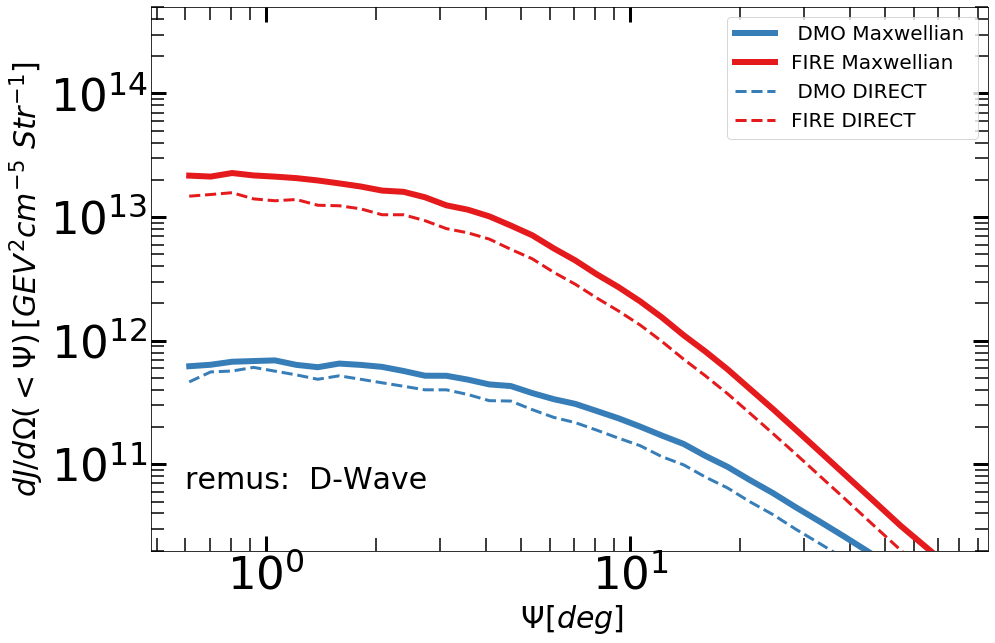

In [105]:
ax_font = 45
txt_font = 45
lw = 4


fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(which='major',width= 3,length=15, direction = 'in', top = True ,right = True, labelsize = ax_font)

ax.tick_params(which='minor',width= 1.5,length=13, direction = 'in', top = True ,right = True, labelsize = ax_font)

plt.xlabel(r'$ \, \Psi [deg] $', fontsize = 30)

plt.ylabel(r'$ dJ/d \Omega (< \Psi) \, [ GEV ^{2} cm^{-5} \ Str^{-1} ]$', fontsize = 30)
    

plt.loglog(DJ_DO_bins_dark_final_final_d, DJ_dark_d ,color =  CB_color_cycle[0],linewidth= 6,label = " DMO Maxwellian " )
plt.loglog(DJ_DO_bins_bary_final_final_d, DJ_bary_d  ,color =  CB_color_cycle[7],linewidth= 6,label = "FIRE Maxwellian" )

# MAG
plt.loglog(DJ_DO_bins_dark_final_final_d_mag, DJ_dark_d_mag ,color =  CB_color_cycle[0],linewidth= 3,label = " DMO DIRECT ",  linestyle='dashed' )
plt.loglog(DJ_DO_bins_bary_final_final_d_mag, DJ_bary_d_mag  ,color =  CB_color_cycle[7],linewidth= 3,label = "FIRE DIRECT",  linestyle='dashed'  )



y_minimum = 2.0e10
y_maximum = 5.0e14   


mpl.pyplot.ylim( y_minimum, y_maximum )


mpl.pyplot.text( 0.6,10**10.8, str(halo)+':  D-Wave', fontsize = 30, color = 'black' )

plt.legend(fontsize = 20)
    #plt.title('Dark Matter Only', fontsize = 30)


    
np.save(path+"/"+'DJ_DO_bins_d_dark'+str(halo)+'.npy',DJ_DO_bins_dark_final_final_d)
np.save(path+"/"+'DJ_DO_bins_d_bary'+str(halo)+'.npy',DJ_DO_bins_bary_final_final_d)
np.save(path+"/"+'DJ_DO_d_dark'+str(halo)+'.npy',DJ_dark_d)
np.save(path+"/"+'DJ_DO_d_bary'+str(halo)+'.npy',DJ_bary_d) 
            
# MAG
np.save(path+"/"+'DJ_DO_bins_d_dark_mag'+str(halo)+'.npy',DJ_DO_bins_dark_final_final_d_mag)
np.save(path+"/"+'DJ_DO_bins_d_bary_mag'+str(halo)+'.npy',DJ_DO_bins_bary_final_final_d_mag)
np.save(path+"/"+'DJ_DO_d_dark_mag'+str(halo)+'.npy',DJ_dark_d_mag)
np.save(path+"/"+'DJ_DO_d_bary_mag'+str(halo)+'.npy',DJ_bary_d_mag)
        
    
    
    
    
plt.savefig(path +'dJ_DO_'+'DWAVE'+str(halo)+'.png',  bbox_inches='tight')
plt.show()